In [31]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa

from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = (12, 5)

                    count  mean   std   min   25%   50%   75%   max
acousticness      13129.0  0.52  0.38  0.00  0.10  0.57  0.92  1.00
danceability      13129.0  0.49  0.19  0.05  0.34  0.49  0.63  0.97
energy            13129.0  0.54  0.28  0.00  0.32  0.55  0.78  1.00
instrumentalness  13129.0  0.64  0.36  0.00  0.32  0.84  0.92  1.00
liveness          13129.0  0.19  0.16  0.03  0.10  0.12  0.21  0.98
speechiness       13129.0  0.10  0.14  0.02  0.04  0.05  0.09  0.97
valence           13129.0  0.44  0.28  0.00  0.20  0.42  0.67  1.00


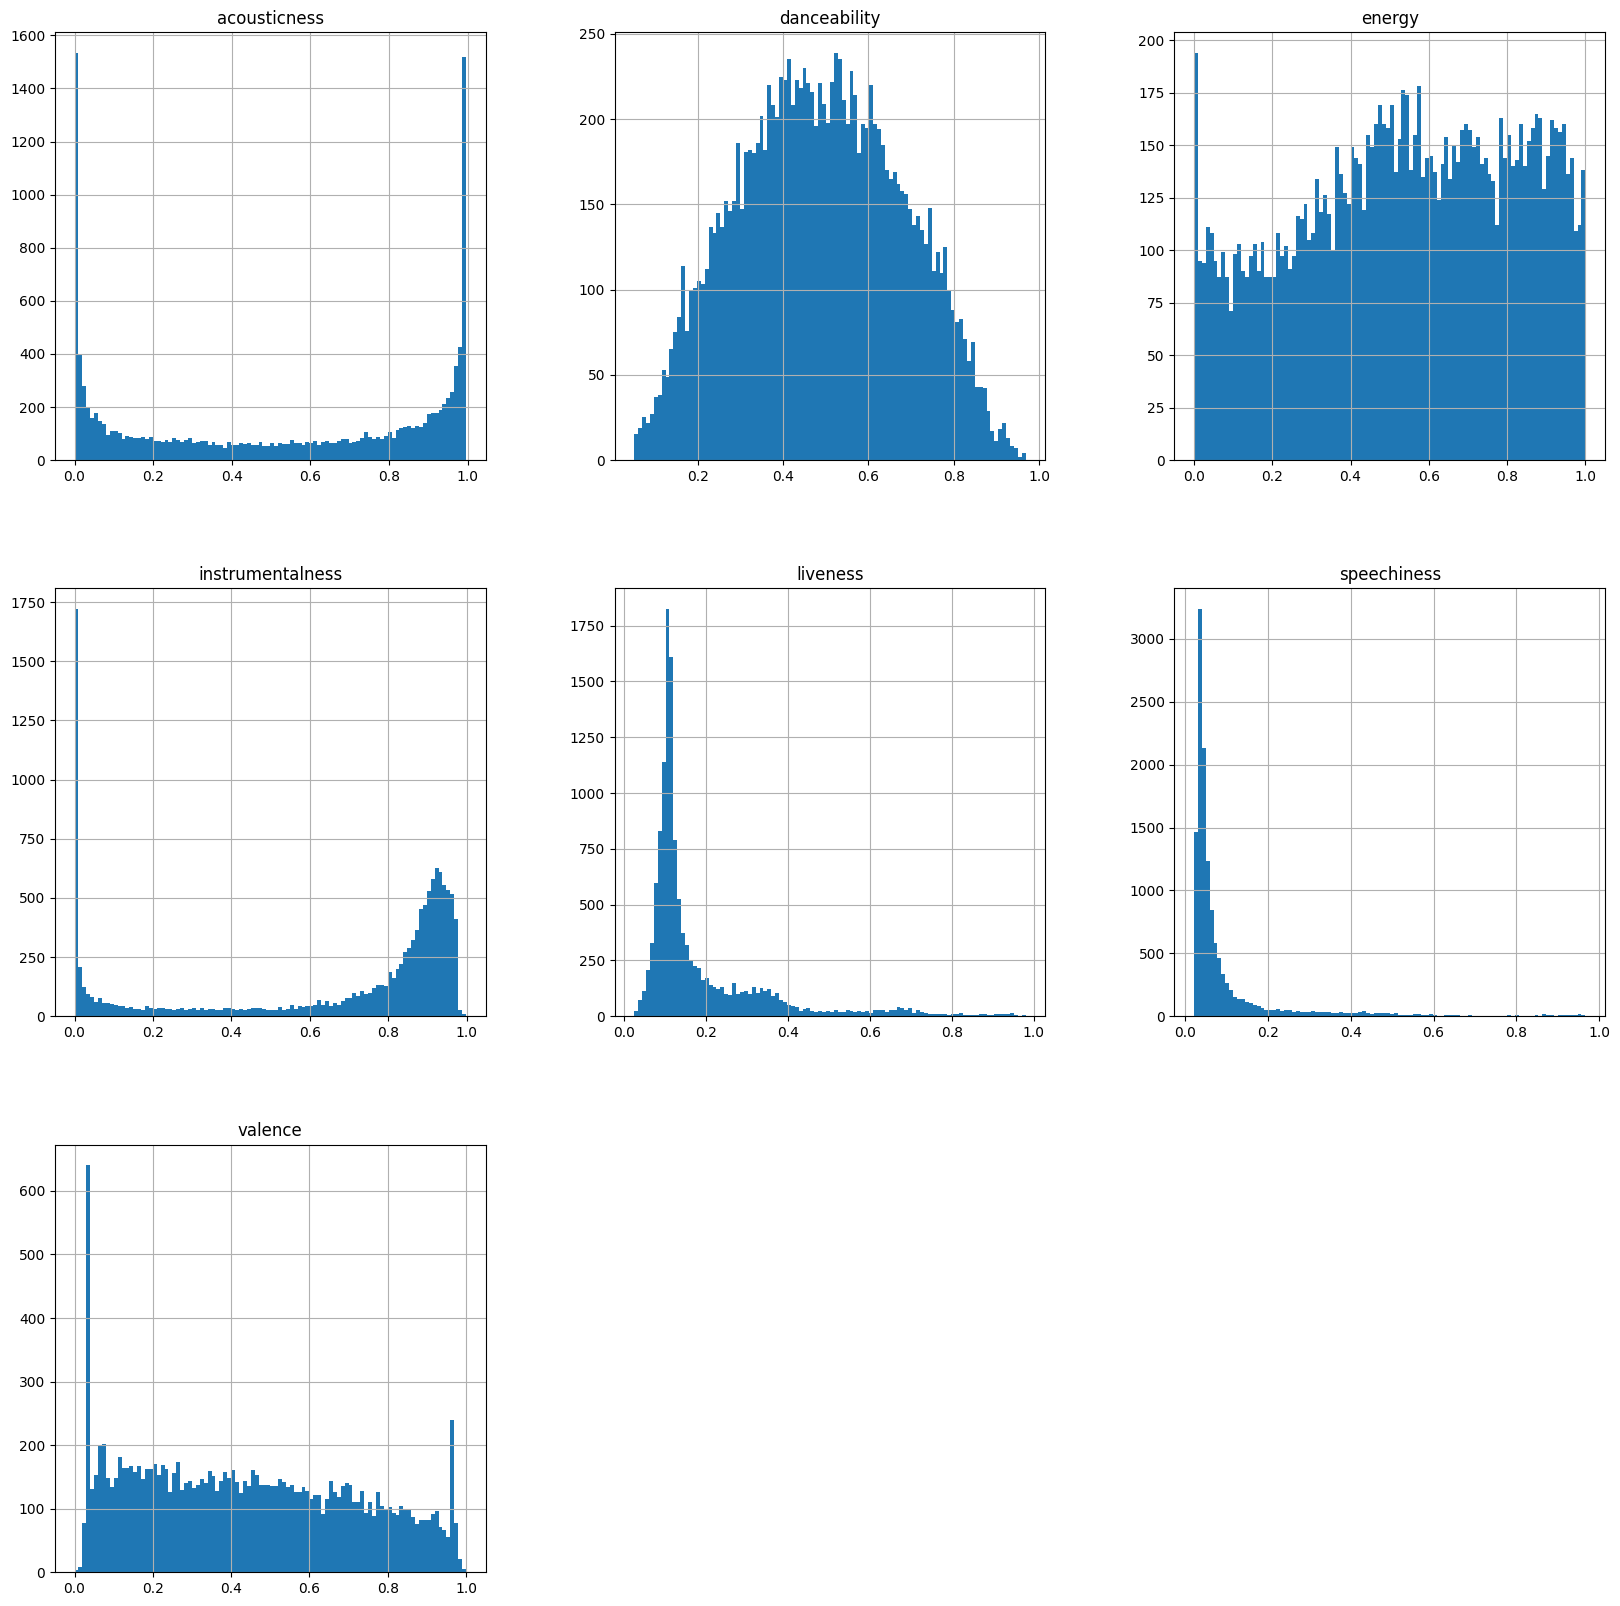

In [3]:
# extract the features from the echonest file
base_dir = '../A4/fma_metadata'  # change this to your own directory
echonest_raw = pd.read_csv(f'{base_dir}/echonest.csv', index_col=0, header=[0, 1, 2])

# extract only the target features
echonest_features = echonest_raw['echonest', 'audio_features']

# drop tempo (will be a model input not target)
echonest_features.drop('tempo', axis=1, inplace=True)

# print histogram to see the distribution of values
echonest_features.hist(bins=100, figsize=(20, 20));

print(echonest_features.describe().T.round(2))

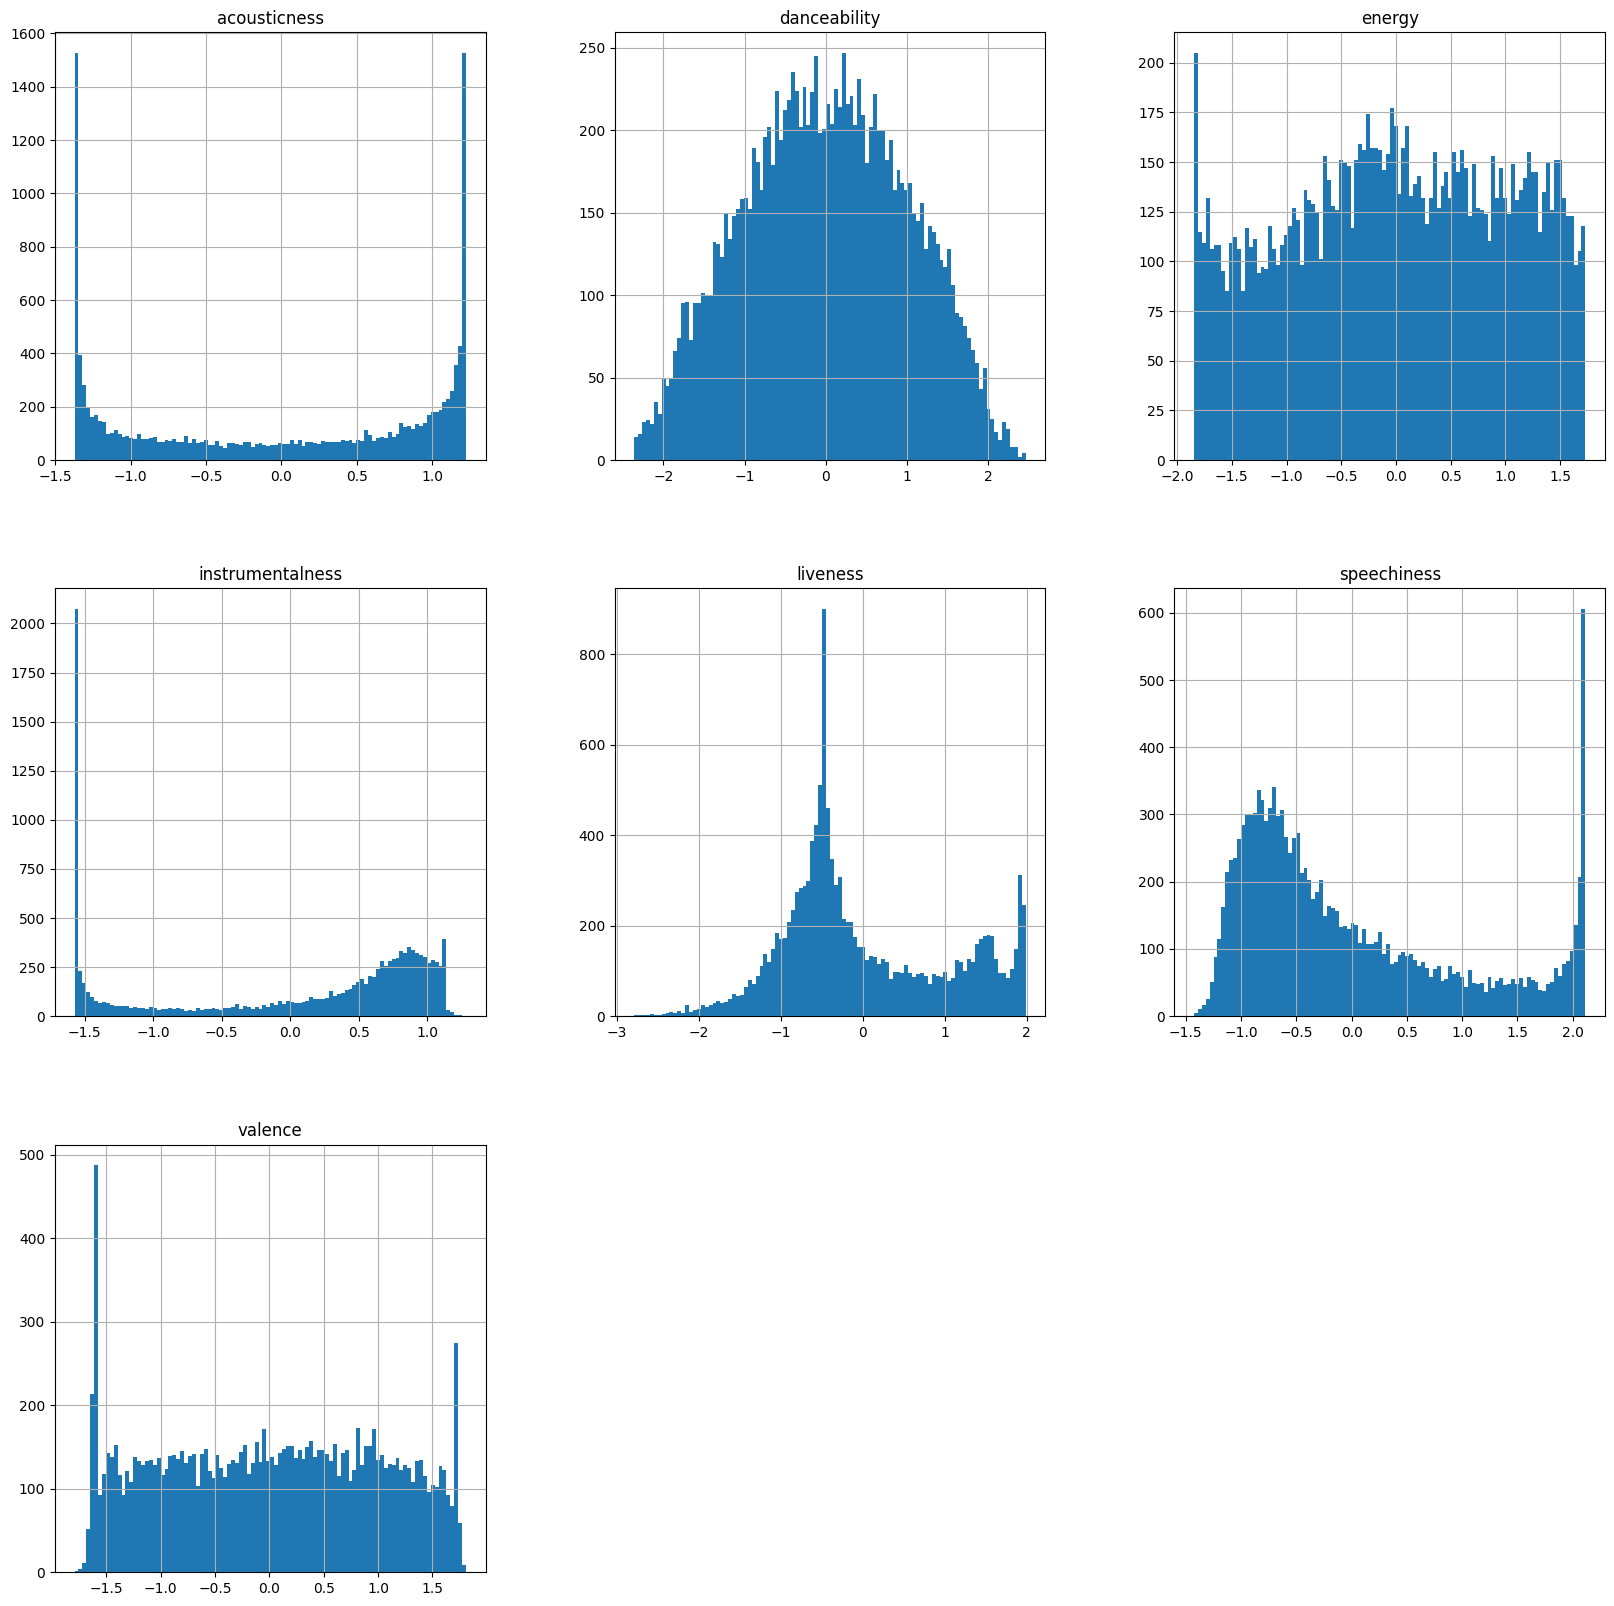

In [4]:
# log scale the echonest features to make them more normally distributed
pt = PowerTransformer()
en_feats_logscale = pd.DataFrame(pt.fit_transform(echonest_features),
                                 columns=echonest_features.columns,
                                 index=echonest_features.index)

en_feats_logscale.hist(bins=100, figsize=(20, 20));

### Thresholding Echonest Scores
Converting echonest numeric scores to binary tags by thresholding at: $mean + coeff * std$

In [5]:
coeff = 0.1
binary_tags = en_feats_logscale.apply(lambda x: (x > x.mean() + coeff*x.std()).astype(int), axis=0)

print(binary_tags.describe().T.round(2))

                    count  mean   std  min  25%  50%  75%  max
acousticness      13129.0  0.51  0.50  0.0  0.0  1.0  1.0  1.0
danceability      13129.0  0.47  0.50  0.0  0.0  0.0  1.0  1.0
energy            13129.0  0.47  0.50  0.0  0.0  0.0  1.0  1.0
instrumentalness  13129.0  0.60  0.49  0.0  0.0  1.0  1.0  1.0
liveness          13129.0  0.36  0.48  0.0  0.0  0.0  1.0  1.0
speechiness       13129.0  0.35  0.48  0.0  0.0  0.0  1.0  1.0
valence           13129.0  0.48  0.50  0.0  0.0  0.0  1.0  1.0


In [6]:
# save the binary targets to a csv file
EN_feature_mapping = {
    "acousticness": "acoustic",
    "danceability": "danceable",
    "energy": "energetic",
    "instrumentalness": "instrumental",
    "liveness": "lively",
    "speechiness": "speechy",
    "valence": "happy"
}
binary_tags.rename(columns=EN_feature_mapping, inplace=True)
binary_tags.to_csv('data/echonest_labels.csv')

### Build Dataset
- Feature extraction with Librosa for model inputs (X_train/X_test)
- Labelling tracks with genre and echonest tags (Y_train/Y_test)

In [7]:
# Get list of audio track file paths
base_dir = '../A4/fma_medium_trimmed'  # change this to your own path
fnames = []
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.wav'):
            file_path = os.path.join(root, file)
            fnames.append(file_path)

print(fnames[:5])

['../A4/fma_medium_trimmed/experimental/113563.wav', '../A4/fma_medium_trimmed/experimental/079976.wav', '../A4/fma_medium_trimmed/experimental/013577.wav', '../A4/fma_medium_trimmed/experimental/145043.wav', '../A4/fma_medium_trimmed/experimental/046238.wav']


In [9]:
# UNCOMMENT THE FOLLOWING CODE TO BUILD DATASET FROM SCRATCH

# tag_df = pd.read_csv('data/echonest_labels.csv', index_col='track_id')

# feats_mean_mfcc = []
# feats_std_mfcc = []
# feats_mean_chroma = []
# feats_std_chroma = []
# feats_tempo = []
# targets = []  # genre and echonest tags

# total = 0
# skipped = 0
# genre_count = {}

# # Iterate over audio files to extract features (model inputs) and targets/labels
# for idx, fname in enumerate(fnames):
#     total += 1

#     # Check if the track ID is in tag_df
#     track_id = int(os.path.basename(fname).split(".")[0])
#     match = tag_df[tag_df.index == track_id]
#     if match.empty:
#         skipped += 1
#         continue
    
#     # Target for a track = genre + echonest tags
#     echonest_tags = match.values.tolist()[0]
#     genre = fname.split(os.sep)[-2]
#     genre_count[genre] = genre_count.get(genre, 0) + 1
#     targets.append(np.hstack([genre] + echonest_tags))

#     # Load the audio file and extract the features
#     print(f'Extracting features for track {idx}', end='\r')
#     audio, srate = librosa.load(fname, res_type='kaiser_fast')
#     mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate, n_mfcc=40)
#     chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=srate)
#     tempo, _ = librosa.beat.beat_track(y=audio, sr=srate)

#     mean_mfcc = np.mean(mfcc_matrix, axis=1)
#     std_mfcc = np.std(mfcc_matrix, axis=1)
#     mean_chroma = np.mean(chroma_cqt, axis=1)
#     std_chroma = np.std(chroma_cqt, axis=1)

#     feats_mean_mfcc.append(mean_mfcc)
#     feats_std_mfcc.append(std_mfcc)
#     feats_mean_chroma.append(mean_chroma)
#     feats_std_chroma.append(std_chroma)
#     feats_tempo.append(tempo)

# # save to disk to avoid re-computing
# np.save('features/feats_mean_mfcc.npy', feats_mean_mfcc)
# np.save('features/feats_std_mfcc.npy', feats_std_mfcc)
# np.save('features/feats_mean_chroma.npy', feats_mean_chroma)
# np.save('features/feats_std_chroma.npy', feats_std_chroma)
# np.save('features/feats_tempo.npy', feats_tempo)
# np.save('features/targets.npy', targets)

# print(f"\nSkipped {skipped}/{total} files")
# print(f"Dataset size: {len(feats_mean_mfcc)}")
# print(f"Genre count: {genre_count}")

Extracting features for track 24984
Skipped 19704/24985 files
Dataset size: 5281
Genre count: {'experimental': 17, 'pop': 231, 'blues': 44, 'instrumental': 55, 'electronic': 1384, 'classical': 174, 'rock': 1844, 'folk': 428, 'hiphop': 530, 'oldtimehistoric': 319, 'international': 108, 'jazz': 147}


In [26]:
# LOAD DATASET FROM DISK IF ALREADY COMPUTED

feats_mean_mfcc = np.load('features/feats_mean_mfcc.npy')
feats_std_mfcc = np.load('features/feats_std_mfcc.npy')
feats_mean_chroma = np.load('features/feats_mean_chroma.npy')
feats_std_chroma = np.load('features/feats_std_chroma.npy')
feats_tempo = np.load('features/feats_tempo.npy').reshape(-1, 1)
y = np.load('features/targets.npy')

### Classification
Model training and evaluation

In [20]:
def eval_classifier(model, X, y, labels, test_size):
    """ Trains and runs a classifier on the given features and targets.
        Displays the confusion matrix and accuracy for each target/label.
    """

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    n_features = y.shape[1]
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten()

    accuracies = {}

    # Train and predict for each target/label
    for i in range(n_features):
        model.fit(X_train, y_train[:, i])
        
        y_pred = model.predict(X_test)
        
        cm = confusion_matrix(y_test[:, i], y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap='YlGnBu')
        axes[i].set_title(f'Feature: {labels[i]}')
        
        acc = accuracy_score(y_test[:, i], y_pred)
        accuracies[labels[i]] = acc

    sns.barplot(x=list(accuracies.values()), y=list(accuracies.keys()), palette='viridis', ax=axes[n_features])
    axes[n_features].set_xlabel('Accuracy')
    axes[n_features].set_ylabel('Target Tag')
    axes[n_features].set_title('Accuracy for each Tag')
    axes[n_features].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    print(f"Feature Accuracies:")
    for feature, acc in accuracies.items():
        print(f"{feature}: {acc:.2f}")
    
    return accuracies

In [29]:
# Evaluate random forest classifier using different feature sets
fsets = {
    'chroma_mean+std': np.hstack([feats_mean_chroma, feats_std_chroma]),
    'mfcc_mean': feats_mean_mfcc,
    'mfcc_mean+std': np.hstack([feats_mean_mfcc, feats_std_mfcc]),
    'mfcc_chroma_mean': np.hstack([feats_mean_mfcc, feats_mean_chroma]),
    'all': np.hstack([feats_mean_mfcc, feats_mean_chroma, feats_std_mfcc, feats_std_chroma, feats_tempo]),
}

for fset in fsets:
    print(fset + " shape: " + str(fsets[fset].shape))

chroma_mean+std shape: (5281, 24)
mfcc_mean shape: (5281, 40)
mfcc_mean+std shape: (5281, 80)
mfcc_chroma_mean shape: (5281, 52)
all shape: (5281, 105)



Evaluating feature set `chroma_mean+std` using SVM classifier:


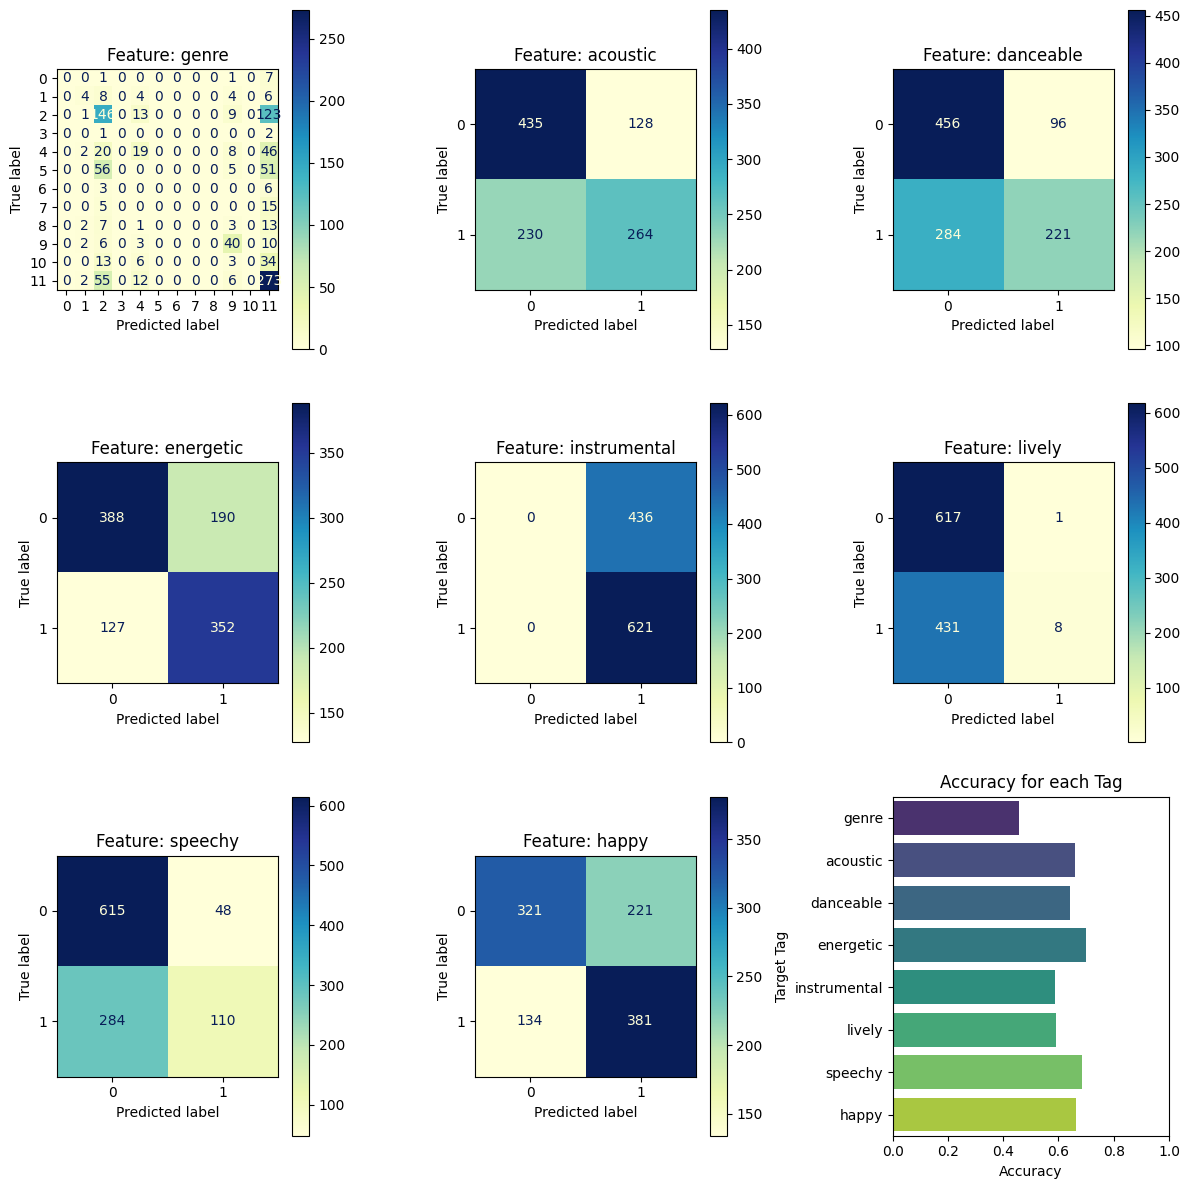

Feature Accuracies:
genre: 0.46
acoustic: 0.66
danceable: 0.64
energetic: 0.70
instrumental: 0.59
lively: 0.59
speechy: 0.69
happy: 0.66

Evaluating feature set `chroma_mean+std` using RandomForest classifier:


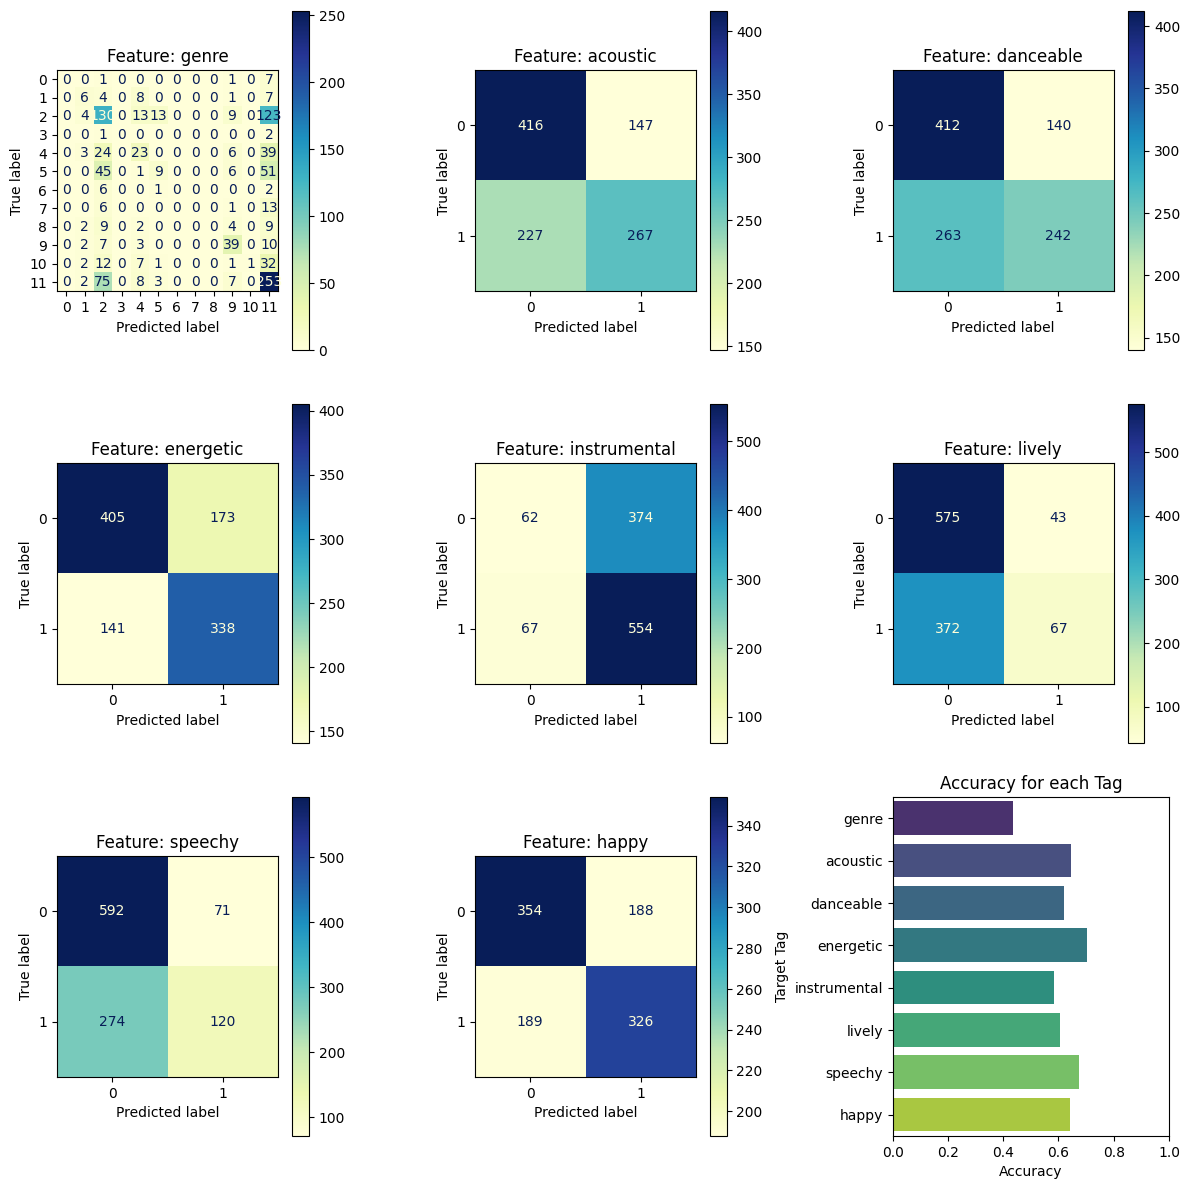

Feature Accuracies:
genre: 0.44
acoustic: 0.65
danceable: 0.62
energetic: 0.70
instrumental: 0.58
lively: 0.61
speechy: 0.67
happy: 0.64

Evaluating feature set `chroma_mean+std` using NaiveBayes classifier:


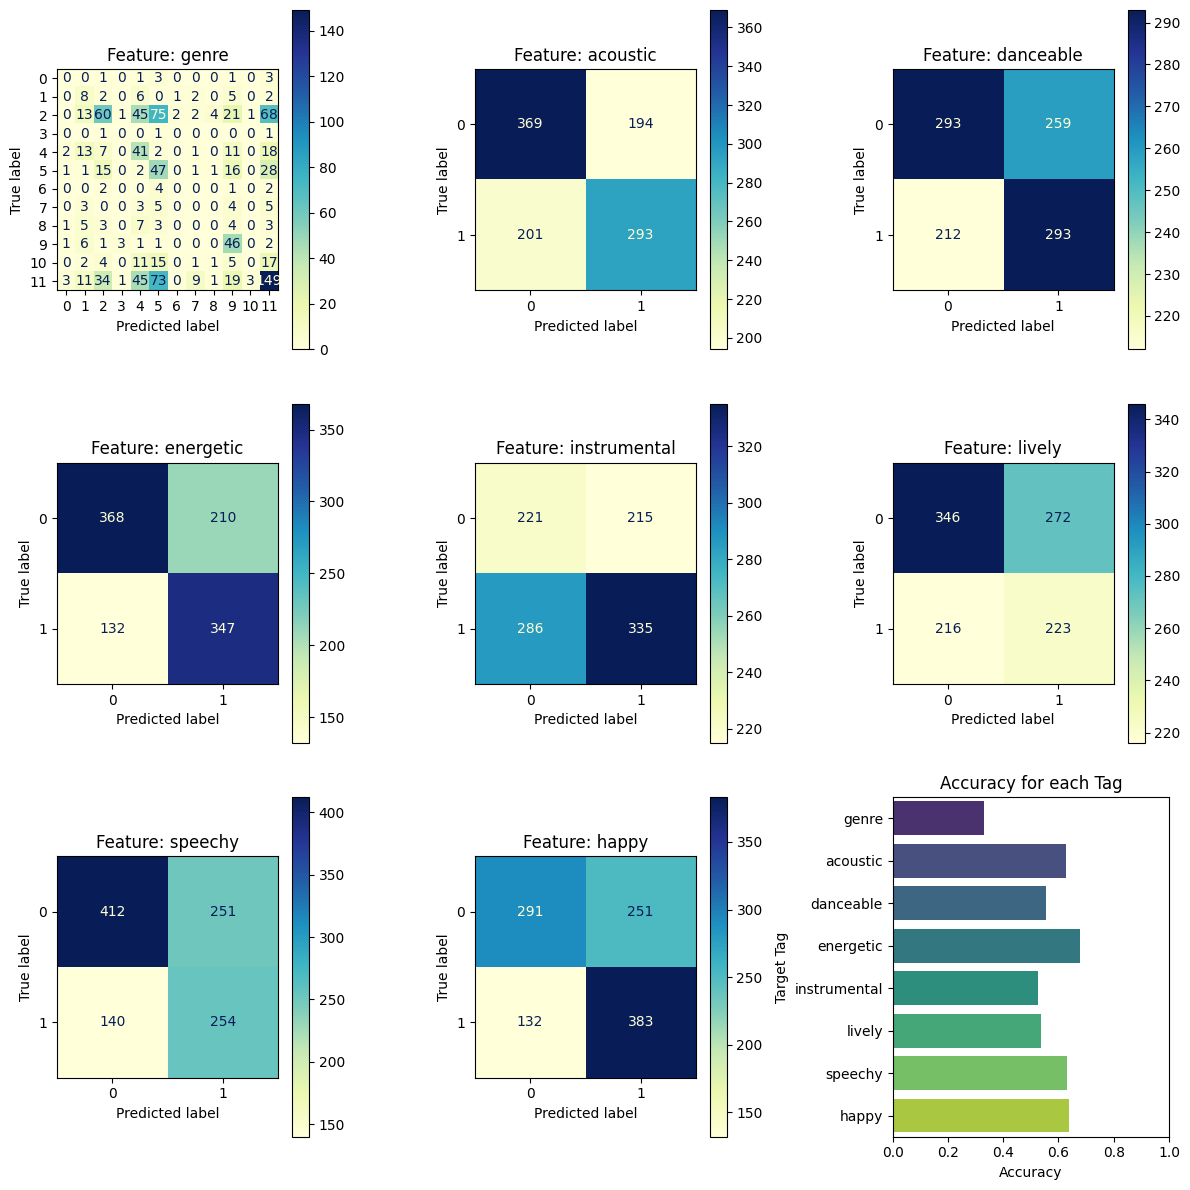

Feature Accuracies:
genre: 0.33
acoustic: 0.63
danceable: 0.55
energetic: 0.68
instrumental: 0.53
lively: 0.54
speechy: 0.63
happy: 0.64

Evaluating feature set `chroma_mean+std` using NeuralNet classifier:


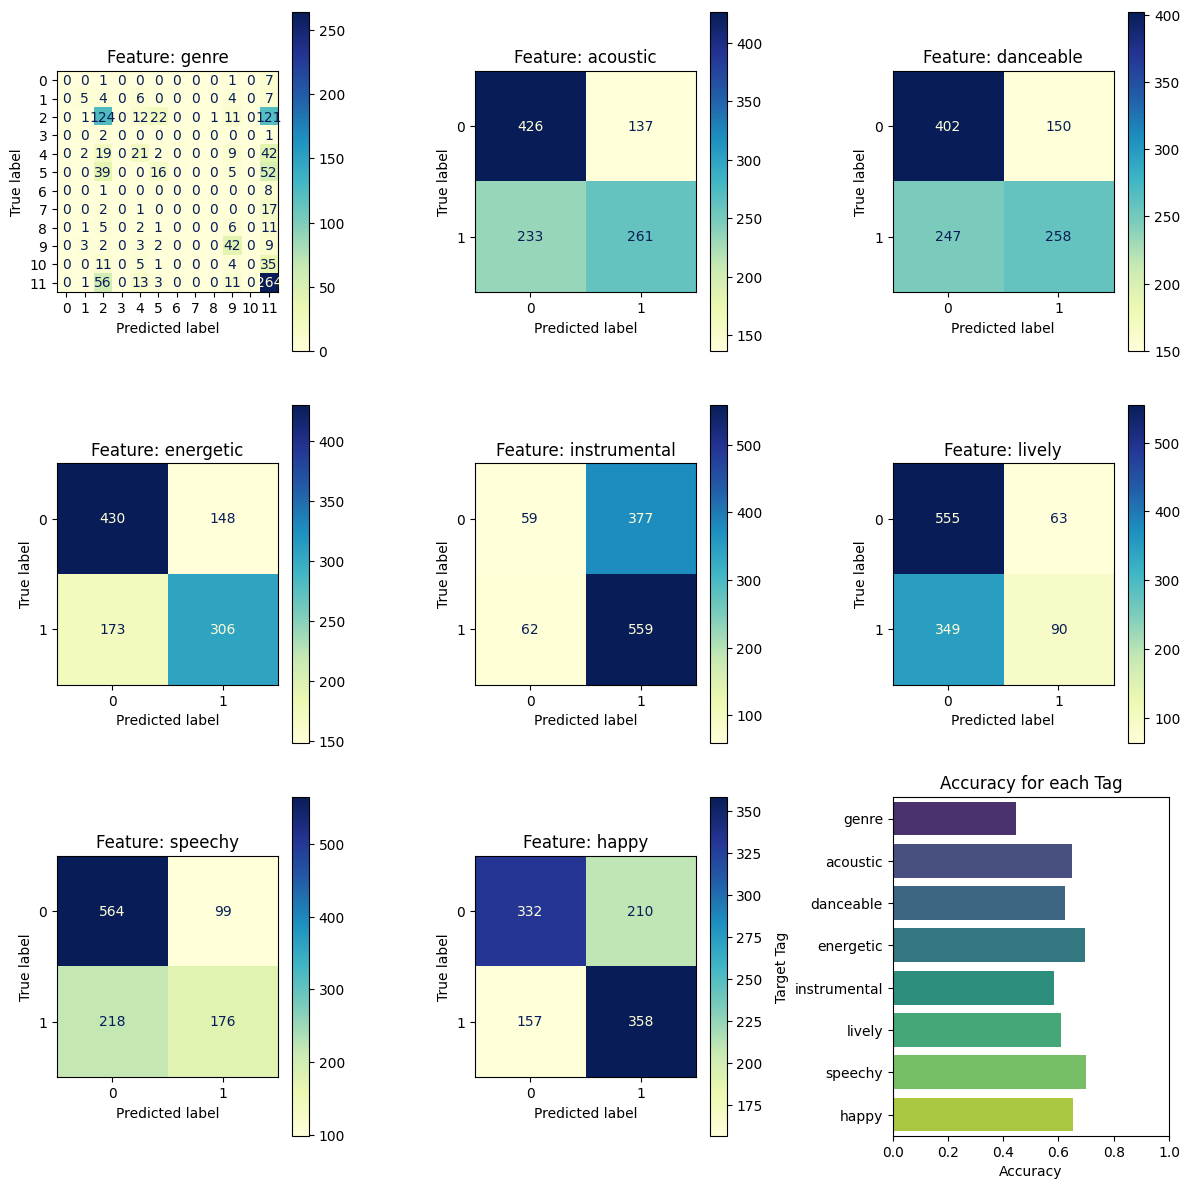

Feature Accuracies:
genre: 0.45
acoustic: 0.65
danceable: 0.62
energetic: 0.70
instrumental: 0.58
lively: 0.61
speechy: 0.70
happy: 0.65

Evaluating feature set `mfcc_mean` using SVM classifier:


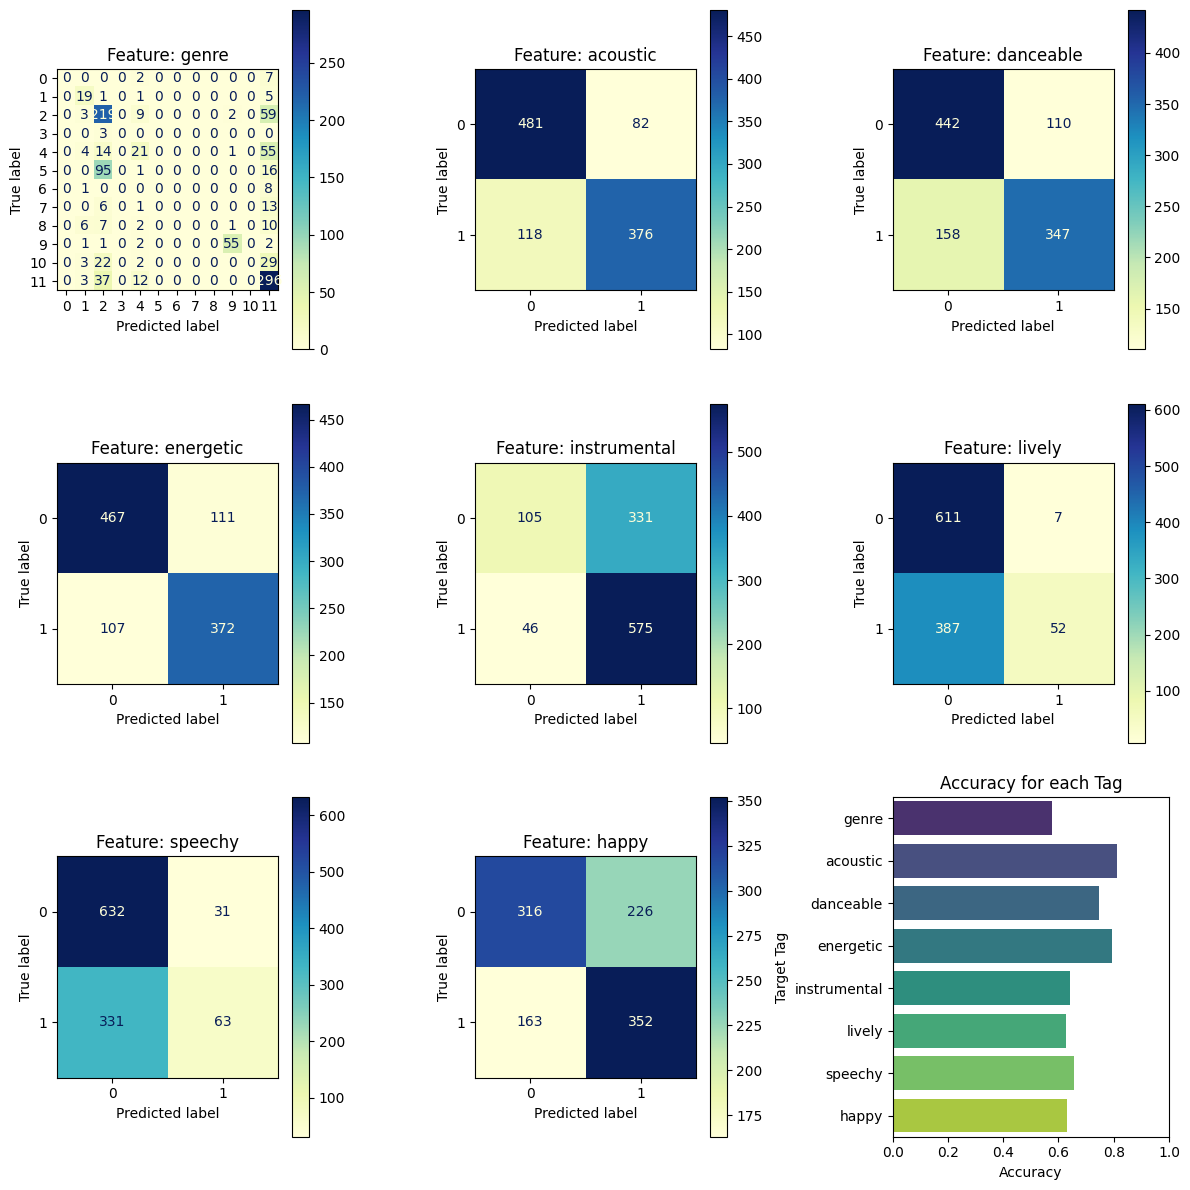

Feature Accuracies:
genre: 0.58
acoustic: 0.81
danceable: 0.75
energetic: 0.79
instrumental: 0.64
lively: 0.63
speechy: 0.66
happy: 0.63

Evaluating feature set `mfcc_mean` using RandomForest classifier:


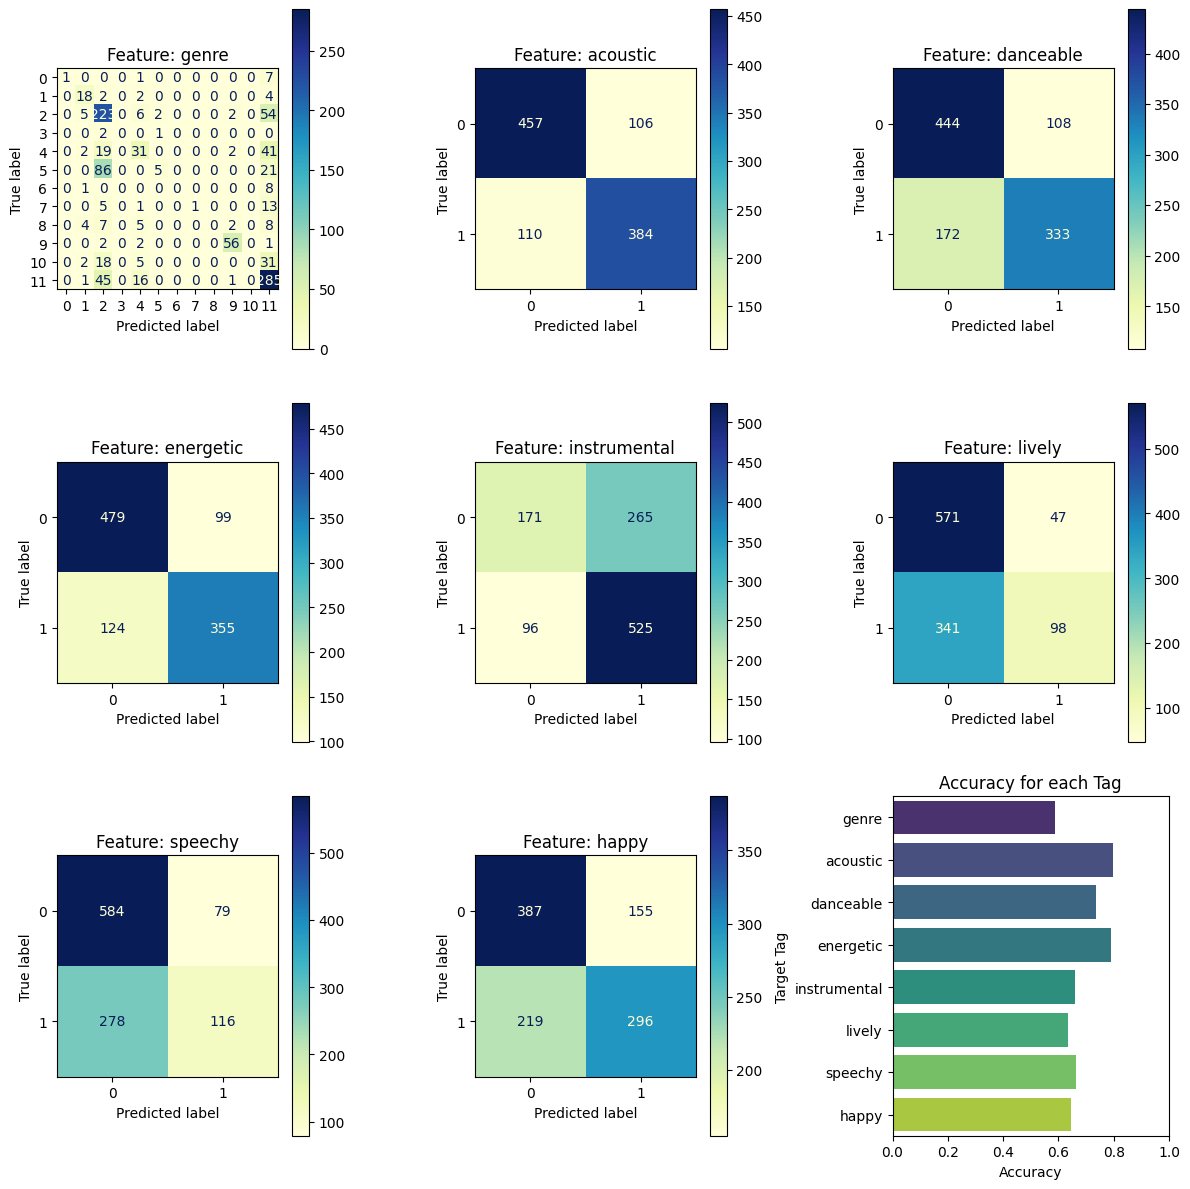

Feature Accuracies:
genre: 0.59
acoustic: 0.80
danceable: 0.74
energetic: 0.79
instrumental: 0.66
lively: 0.63
speechy: 0.66
happy: 0.65

Evaluating feature set `mfcc_mean` using NaiveBayes classifier:


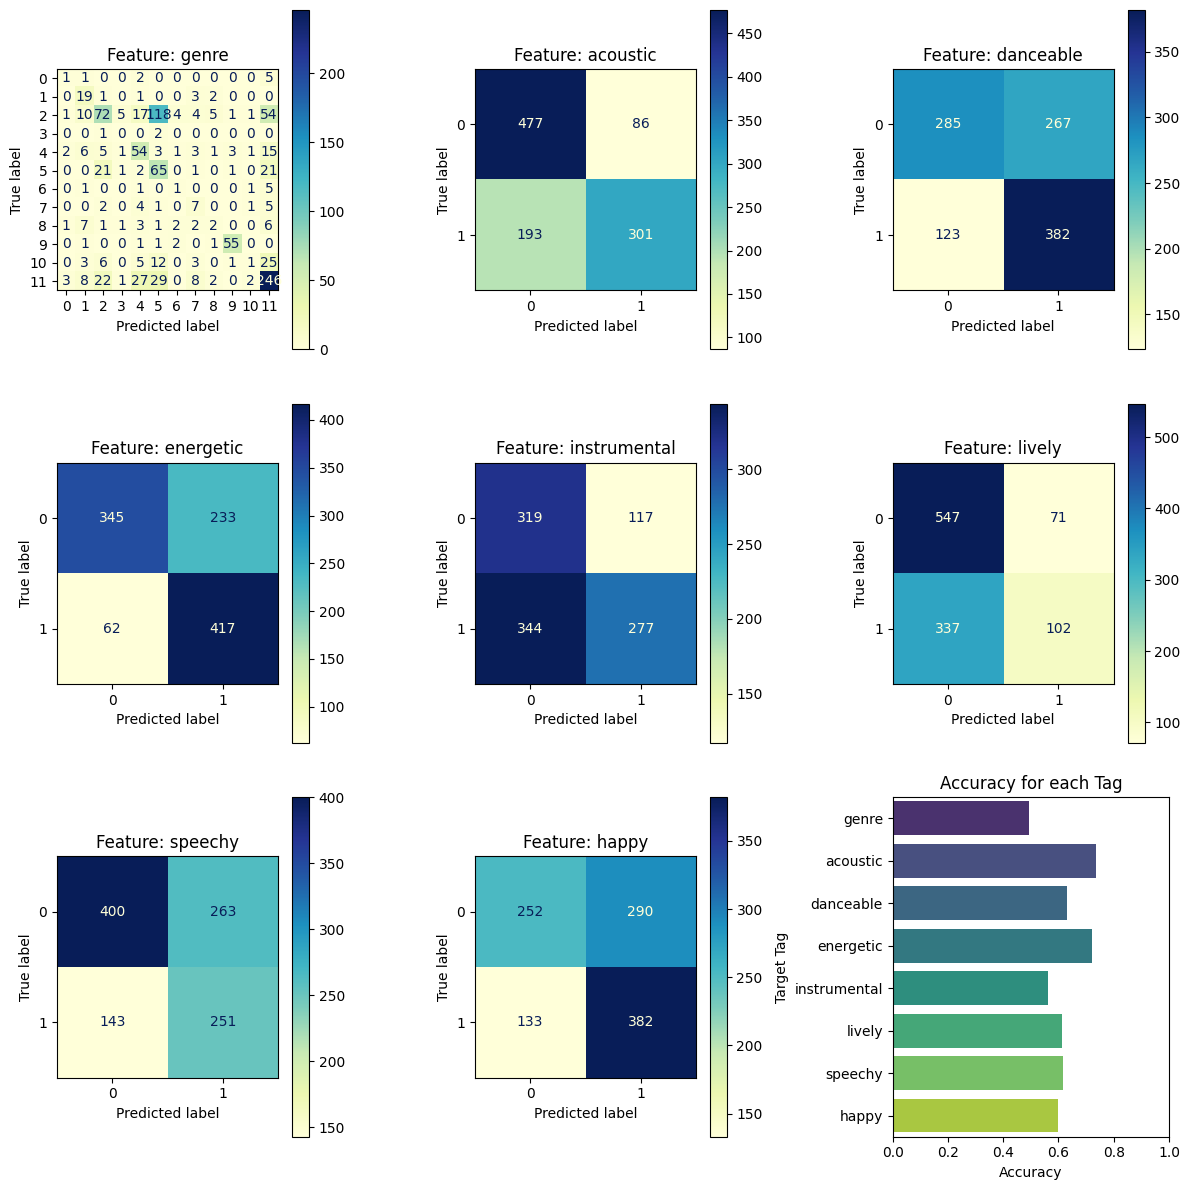

Feature Accuracies:
genre: 0.49
acoustic: 0.74
danceable: 0.63
energetic: 0.72
instrumental: 0.56
lively: 0.61
speechy: 0.62
happy: 0.60

Evaluating feature set `mfcc_mean` using NeuralNet classifier:


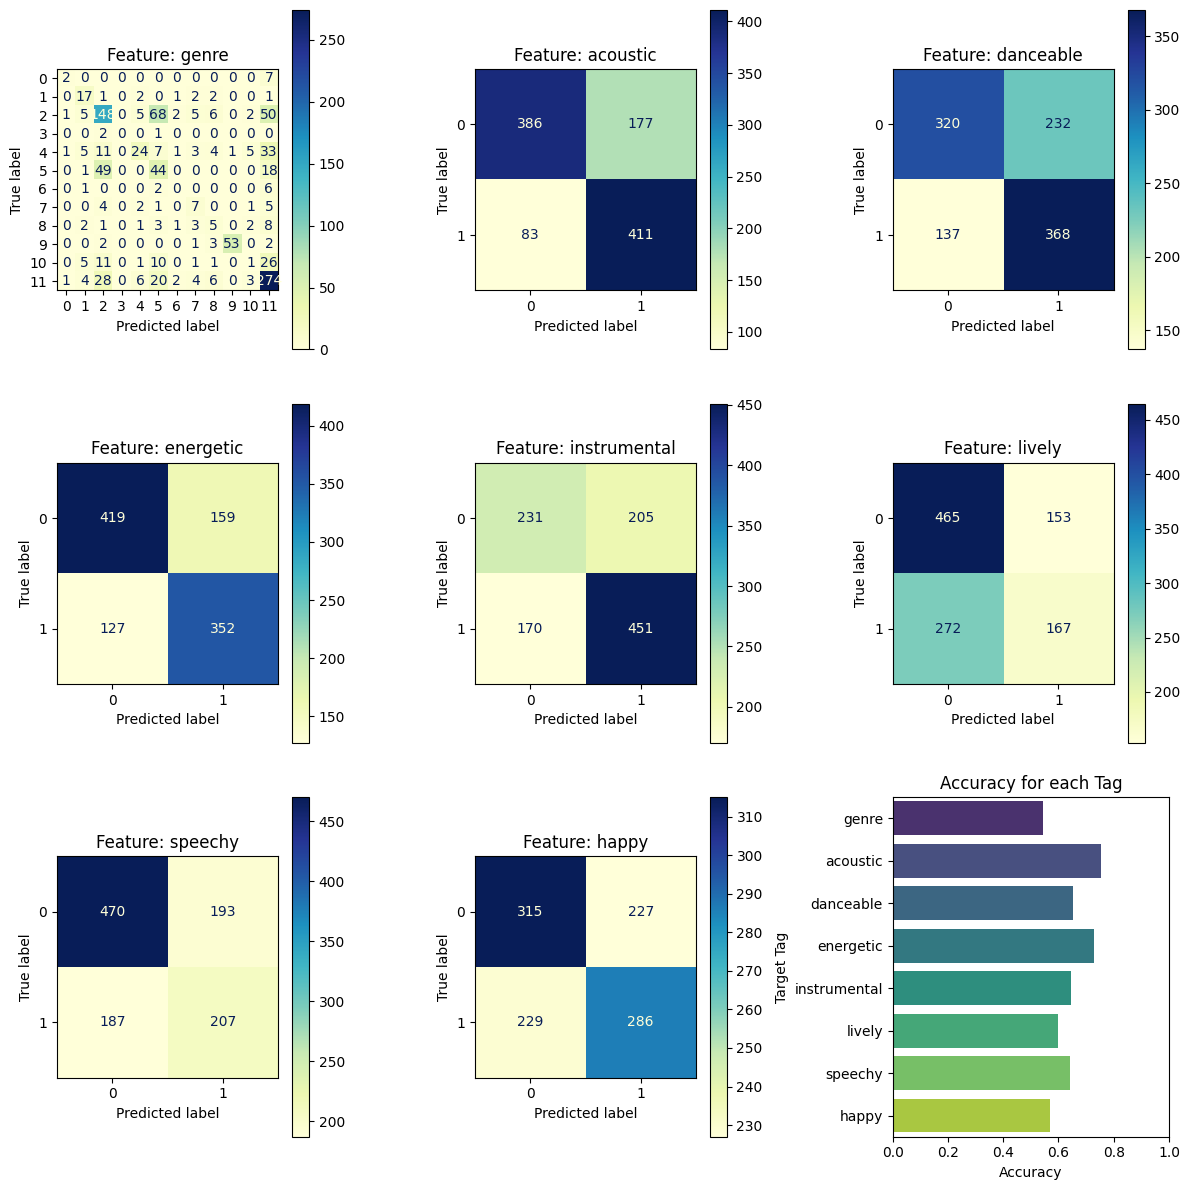

Feature Accuracies:
genre: 0.54
acoustic: 0.75
danceable: 0.65
energetic: 0.73
instrumental: 0.65
lively: 0.60
speechy: 0.64
happy: 0.57

Evaluating feature set `mfcc_mean+std` using SVM classifier:


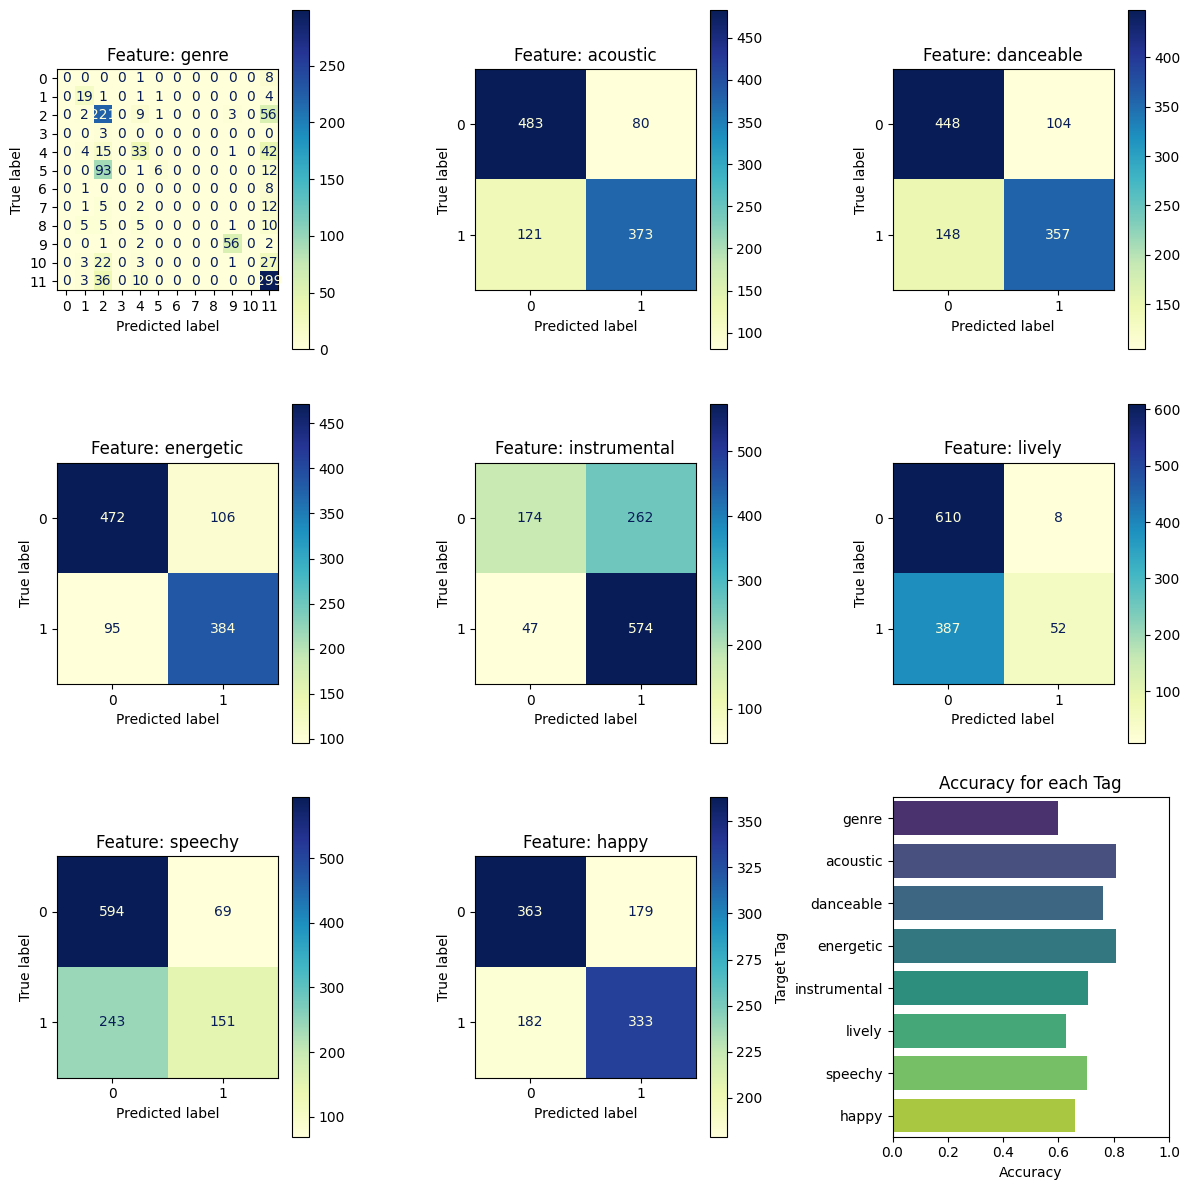

Feature Accuracies:
genre: 0.60
acoustic: 0.81
danceable: 0.76
energetic: 0.81
instrumental: 0.71
lively: 0.63
speechy: 0.70
happy: 0.66

Evaluating feature set `mfcc_mean+std` using RandomForest classifier:


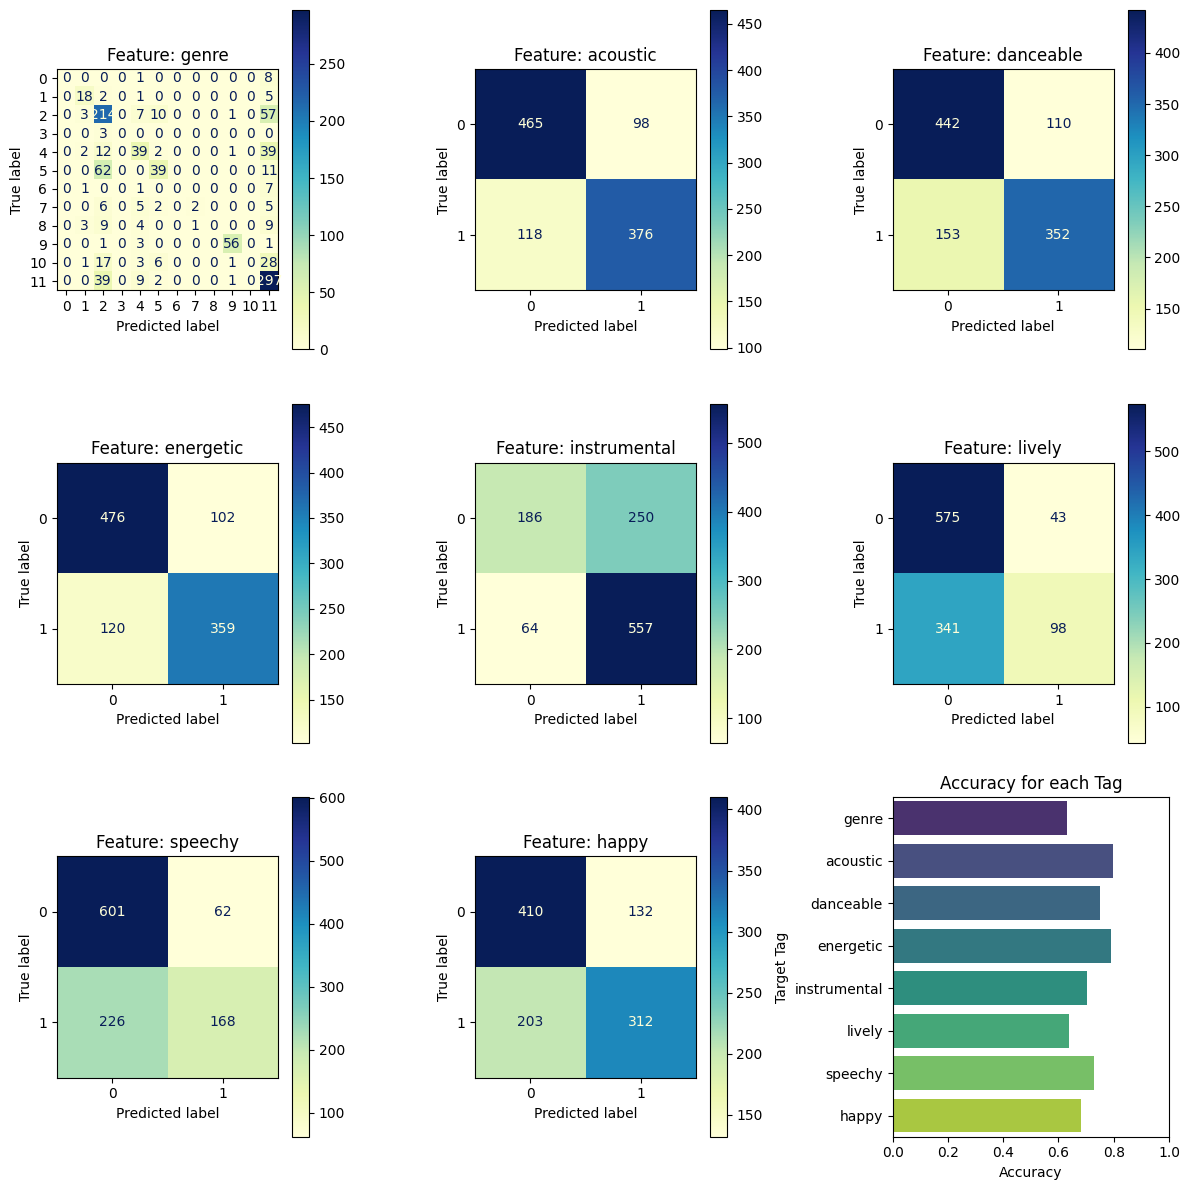

Feature Accuracies:
genre: 0.63
acoustic: 0.80
danceable: 0.75
energetic: 0.79
instrumental: 0.70
lively: 0.64
speechy: 0.73
happy: 0.68

Evaluating feature set `mfcc_mean+std` using NaiveBayes classifier:


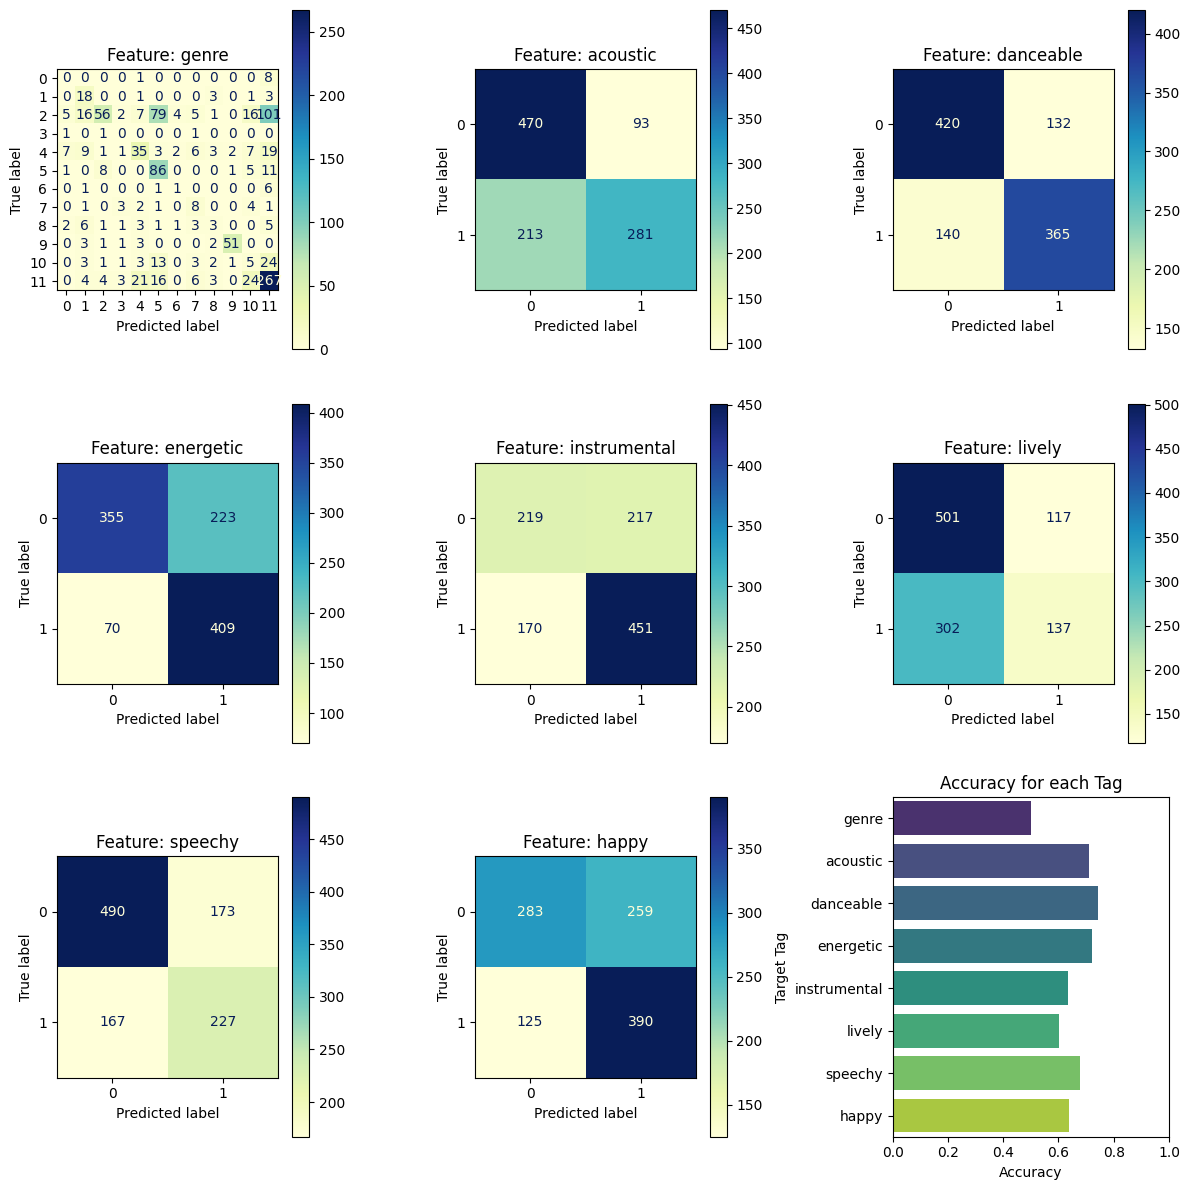

Feature Accuracies:
genre: 0.50
acoustic: 0.71
danceable: 0.74
energetic: 0.72
instrumental: 0.63
lively: 0.60
speechy: 0.68
happy: 0.64

Evaluating feature set `mfcc_mean+std` using NeuralNet classifier:


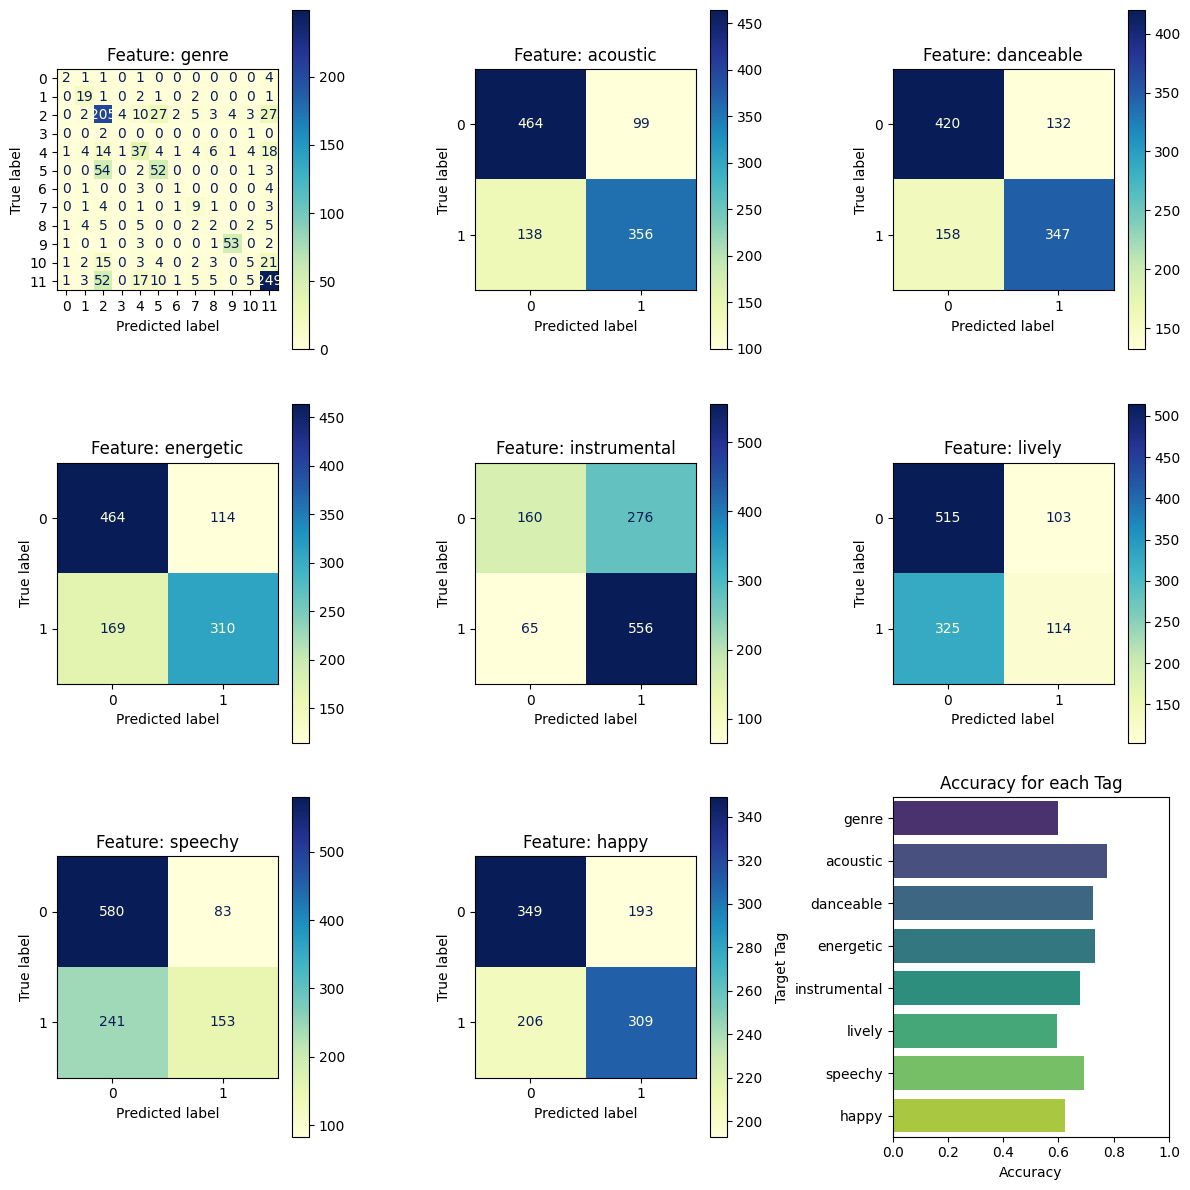

Feature Accuracies:
genre: 0.60
acoustic: 0.78
danceable: 0.73
energetic: 0.73
instrumental: 0.68
lively: 0.60
speechy: 0.69
happy: 0.62

Evaluating feature set `mfcc_chroma_mean` using SVM classifier:


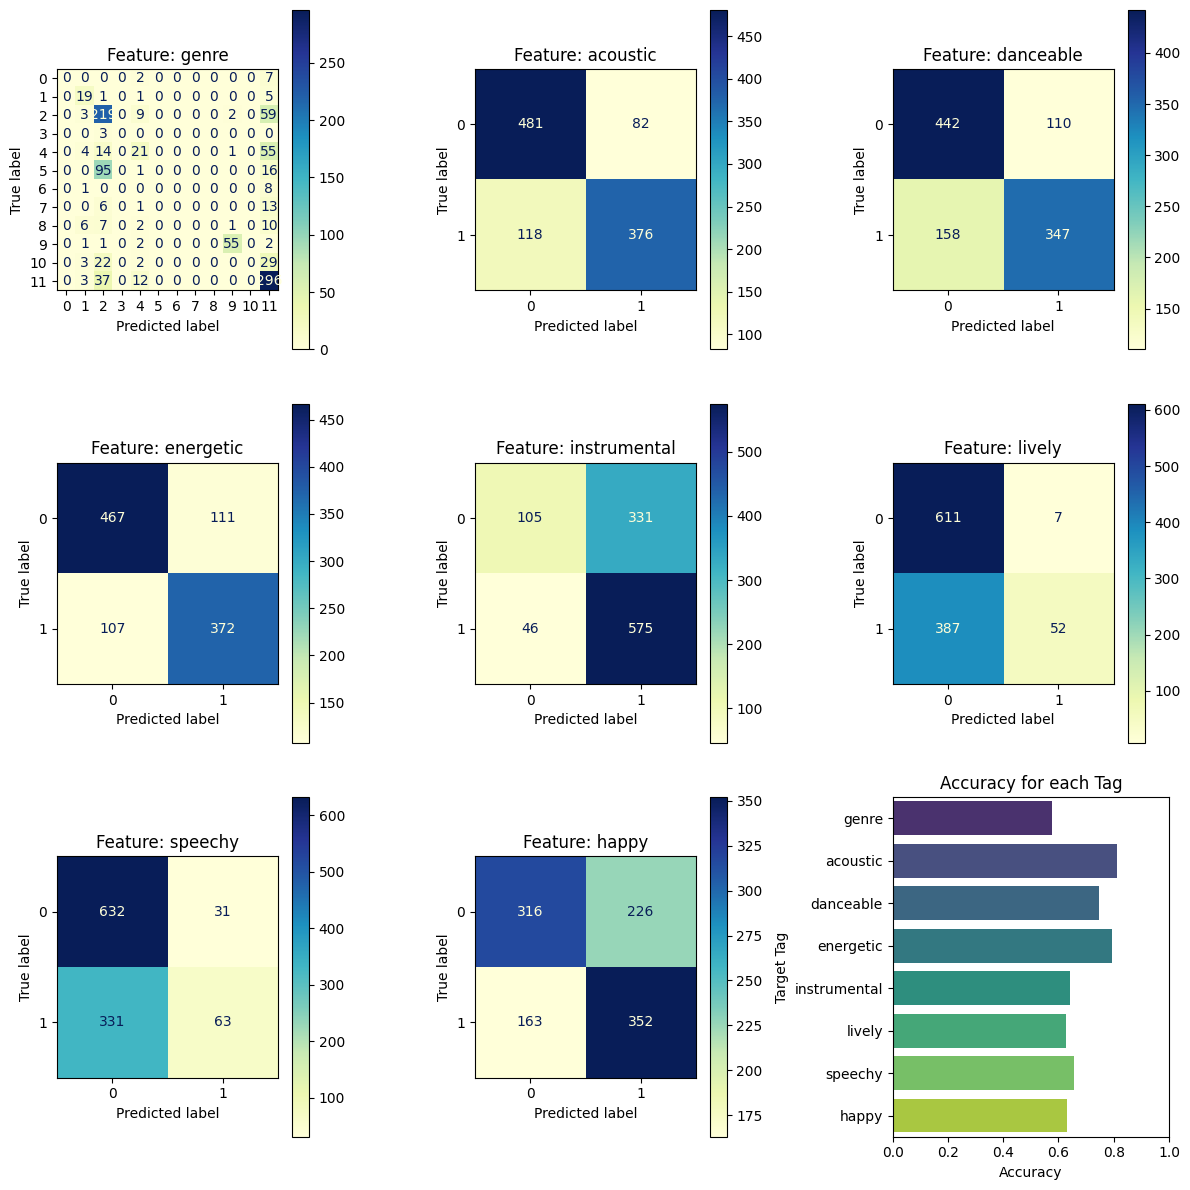

Feature Accuracies:
genre: 0.58
acoustic: 0.81
danceable: 0.75
energetic: 0.79
instrumental: 0.64
lively: 0.63
speechy: 0.66
happy: 0.63

Evaluating feature set `mfcc_chroma_mean` using RandomForest classifier:


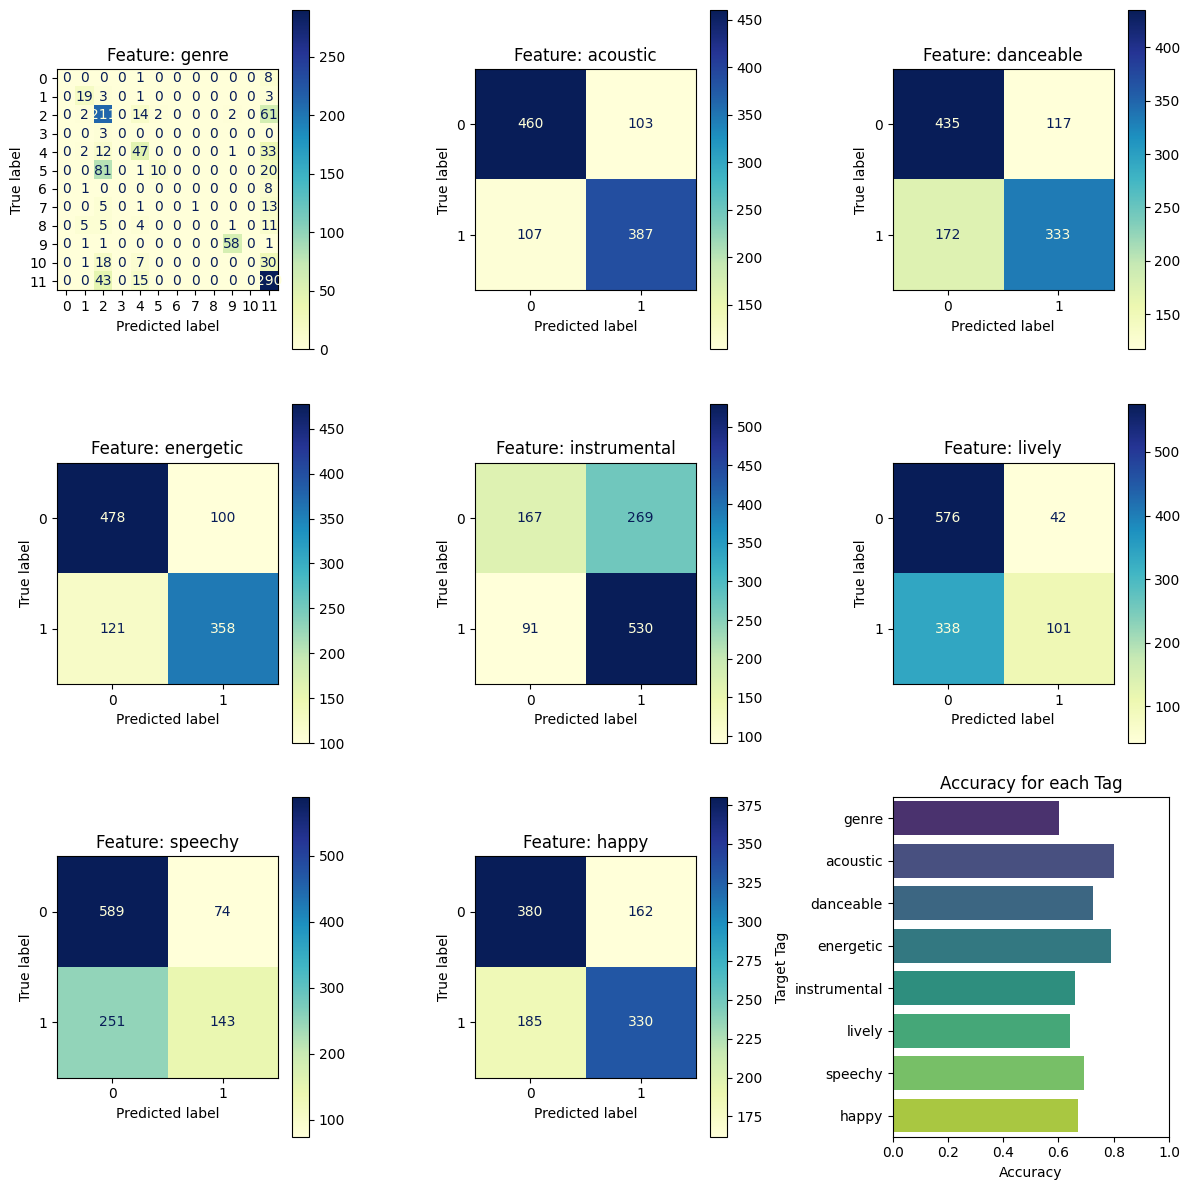

Feature Accuracies:
genre: 0.60
acoustic: 0.80
danceable: 0.73
energetic: 0.79
instrumental: 0.66
lively: 0.64
speechy: 0.69
happy: 0.67

Evaluating feature set `mfcc_chroma_mean` using NaiveBayes classifier:


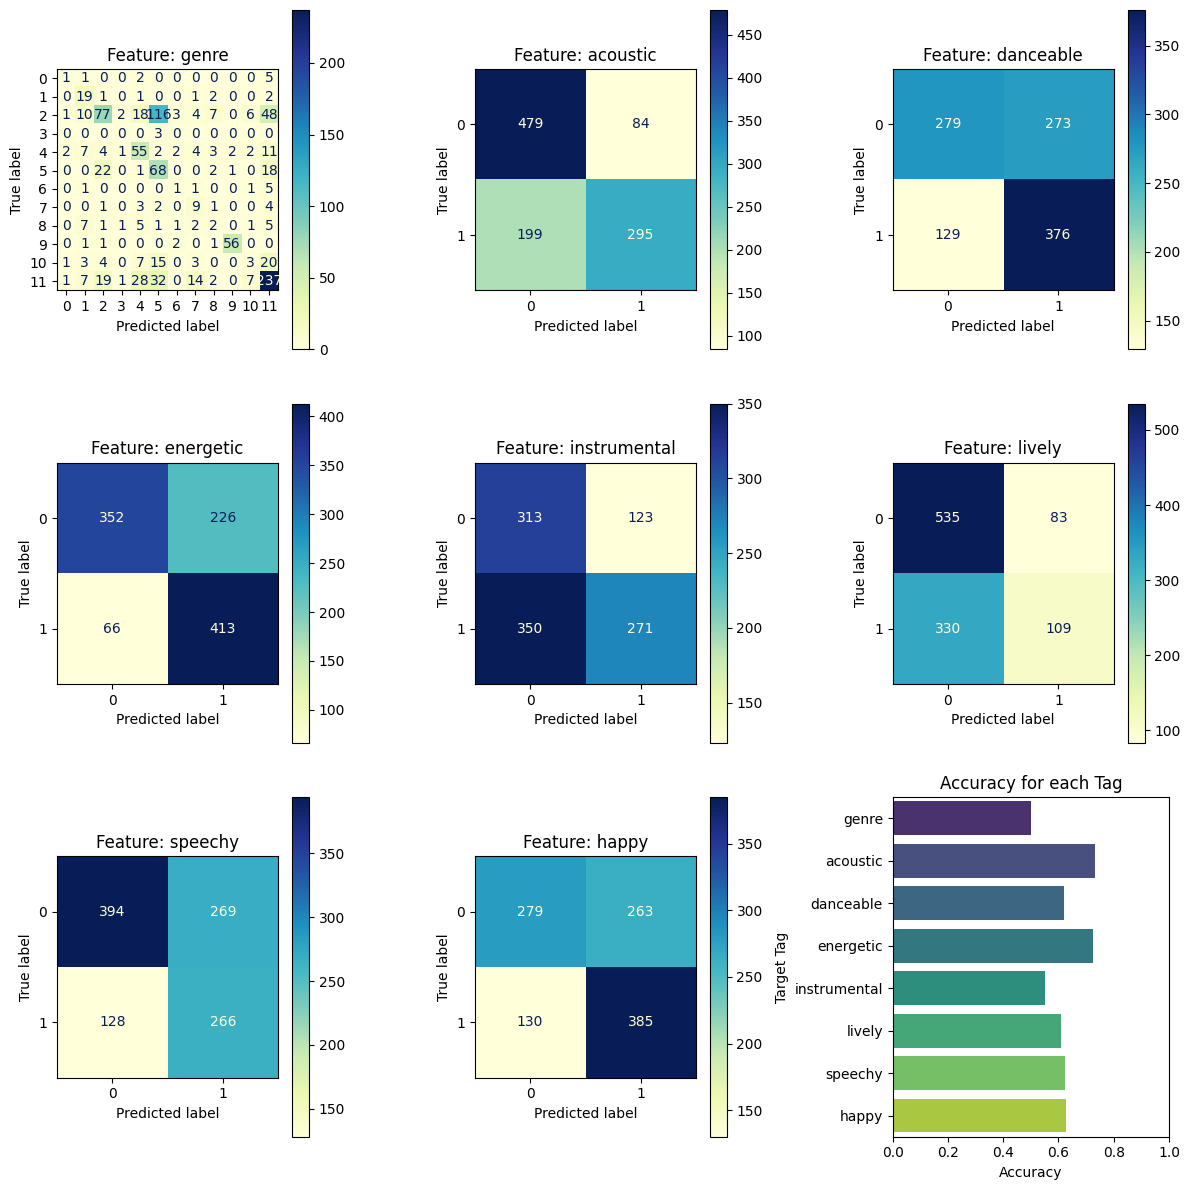

Feature Accuracies:
genre: 0.50
acoustic: 0.73
danceable: 0.62
energetic: 0.72
instrumental: 0.55
lively: 0.61
speechy: 0.62
happy: 0.63

Evaluating feature set `mfcc_chroma_mean` using NeuralNet classifier:


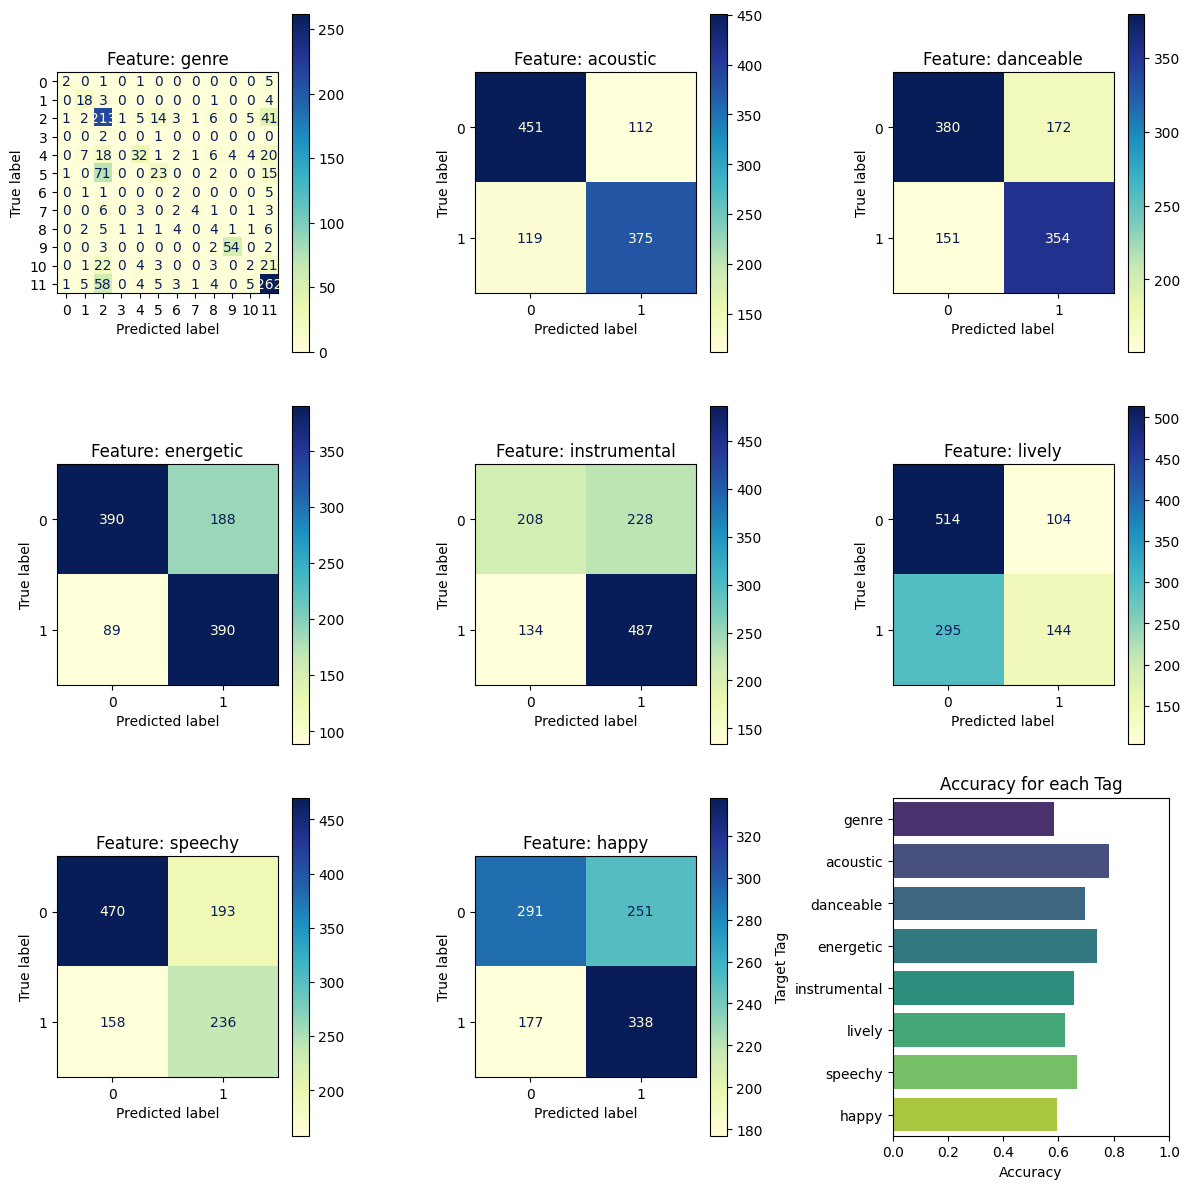

Feature Accuracies:
genre: 0.58
acoustic: 0.78
danceable: 0.69
energetic: 0.74
instrumental: 0.66
lively: 0.62
speechy: 0.67
happy: 0.60

Evaluating feature set `all` using SVM classifier:


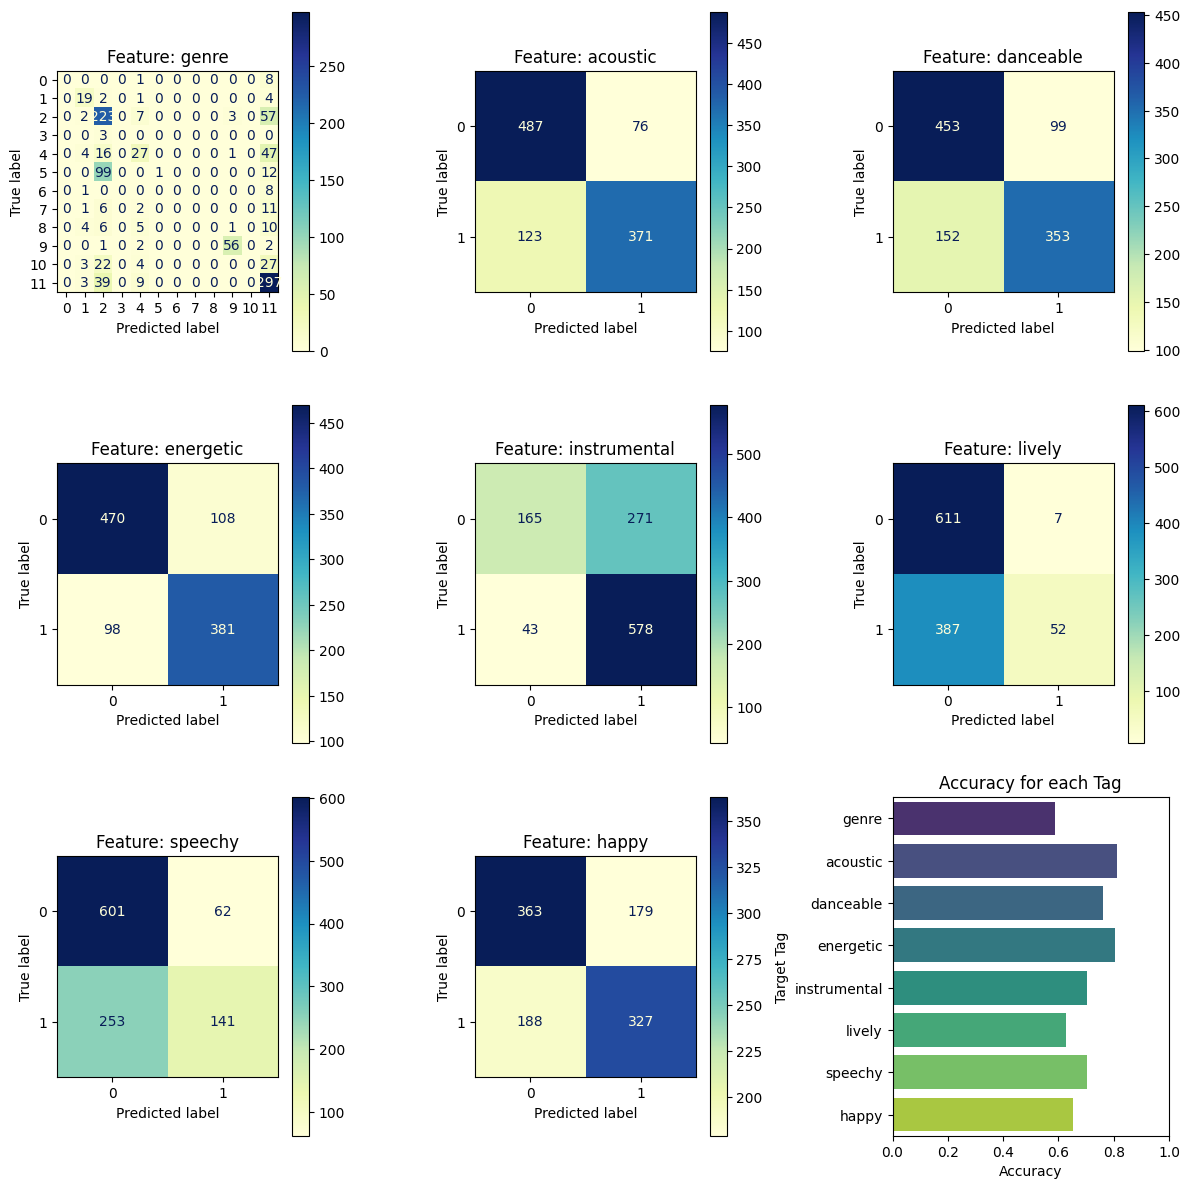

Feature Accuracies:
genre: 0.59
acoustic: 0.81
danceable: 0.76
energetic: 0.81
instrumental: 0.70
lively: 0.63
speechy: 0.70
happy: 0.65

Evaluating feature set `all` using RandomForest classifier:


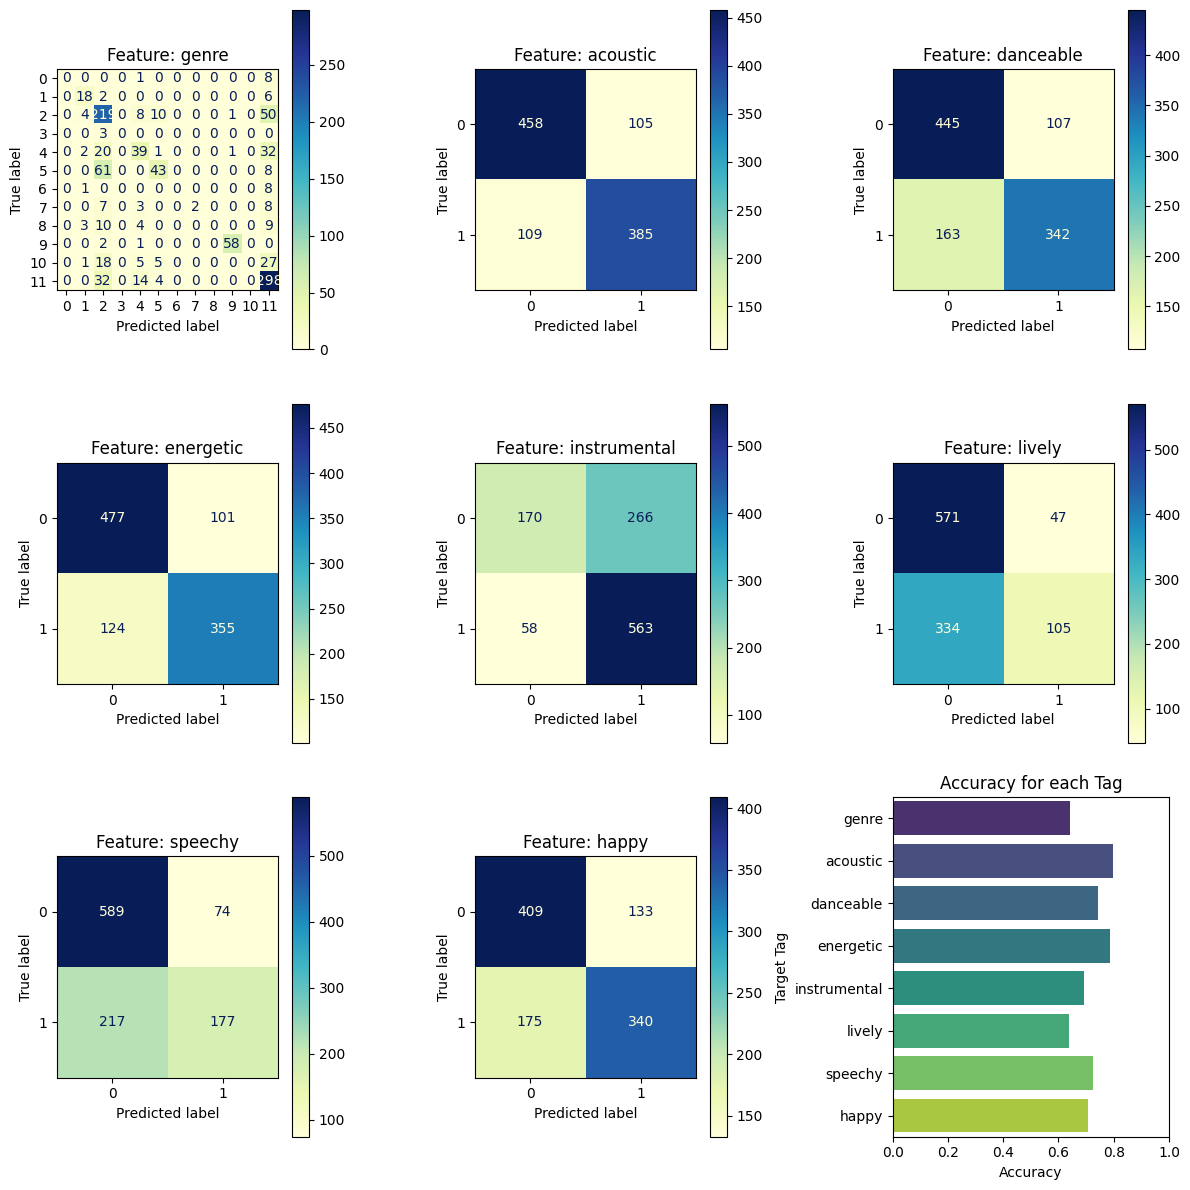

Feature Accuracies:
genre: 0.64
acoustic: 0.80
danceable: 0.74
energetic: 0.79
instrumental: 0.69
lively: 0.64
speechy: 0.72
happy: 0.71

Evaluating feature set `all` using NaiveBayes classifier:


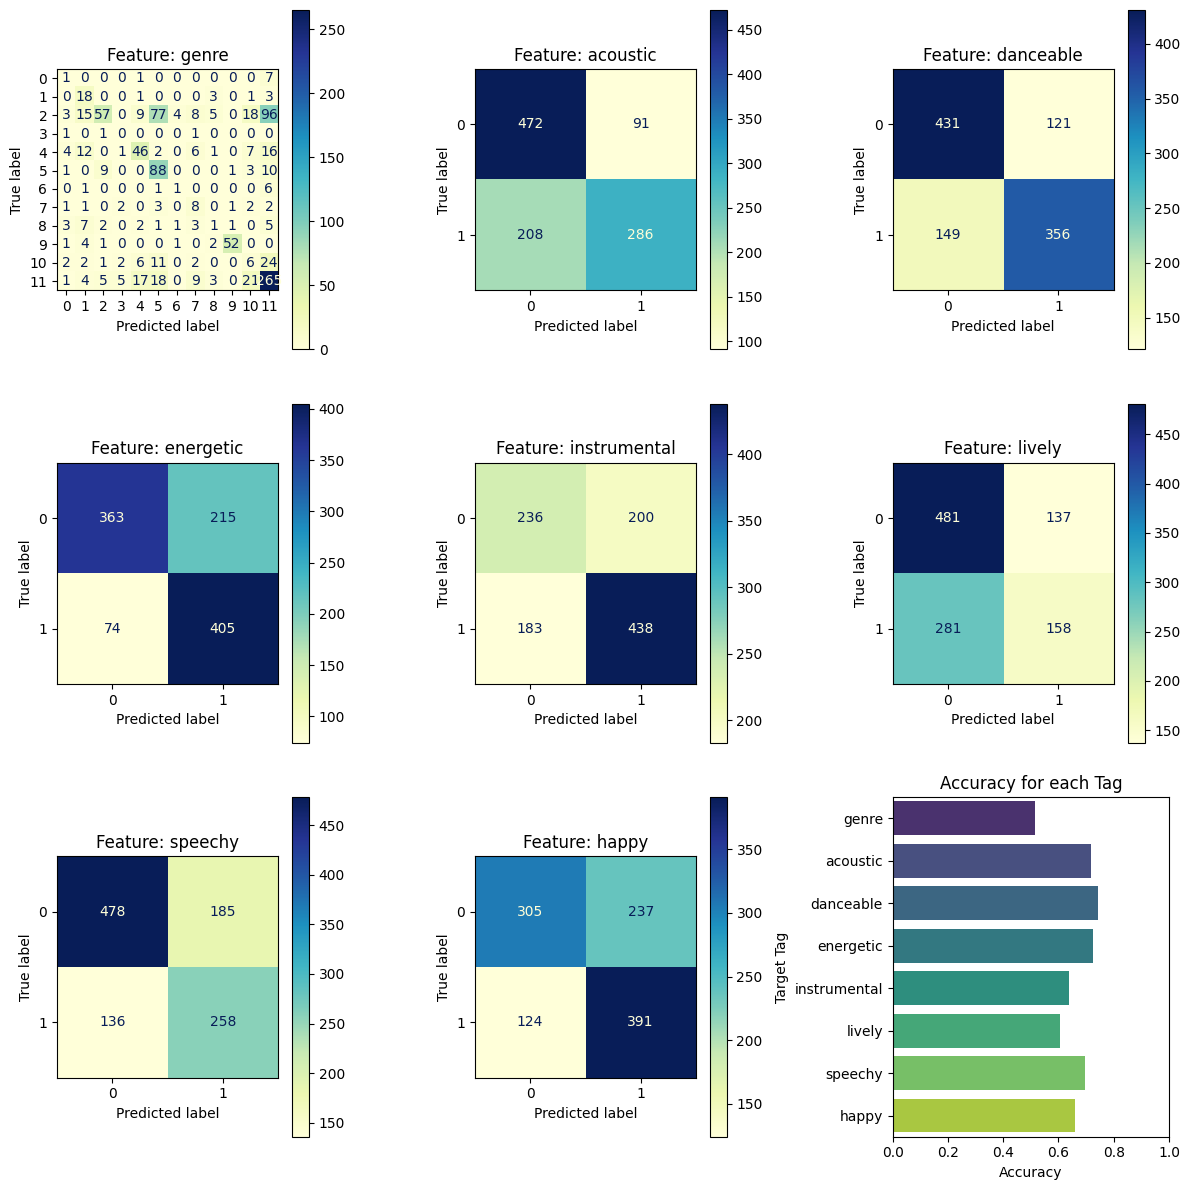

Feature Accuracies:
genre: 0.51
acoustic: 0.72
danceable: 0.74
energetic: 0.73
instrumental: 0.64
lively: 0.60
speechy: 0.70
happy: 0.66

Evaluating feature set `all` using NeuralNet classifier:


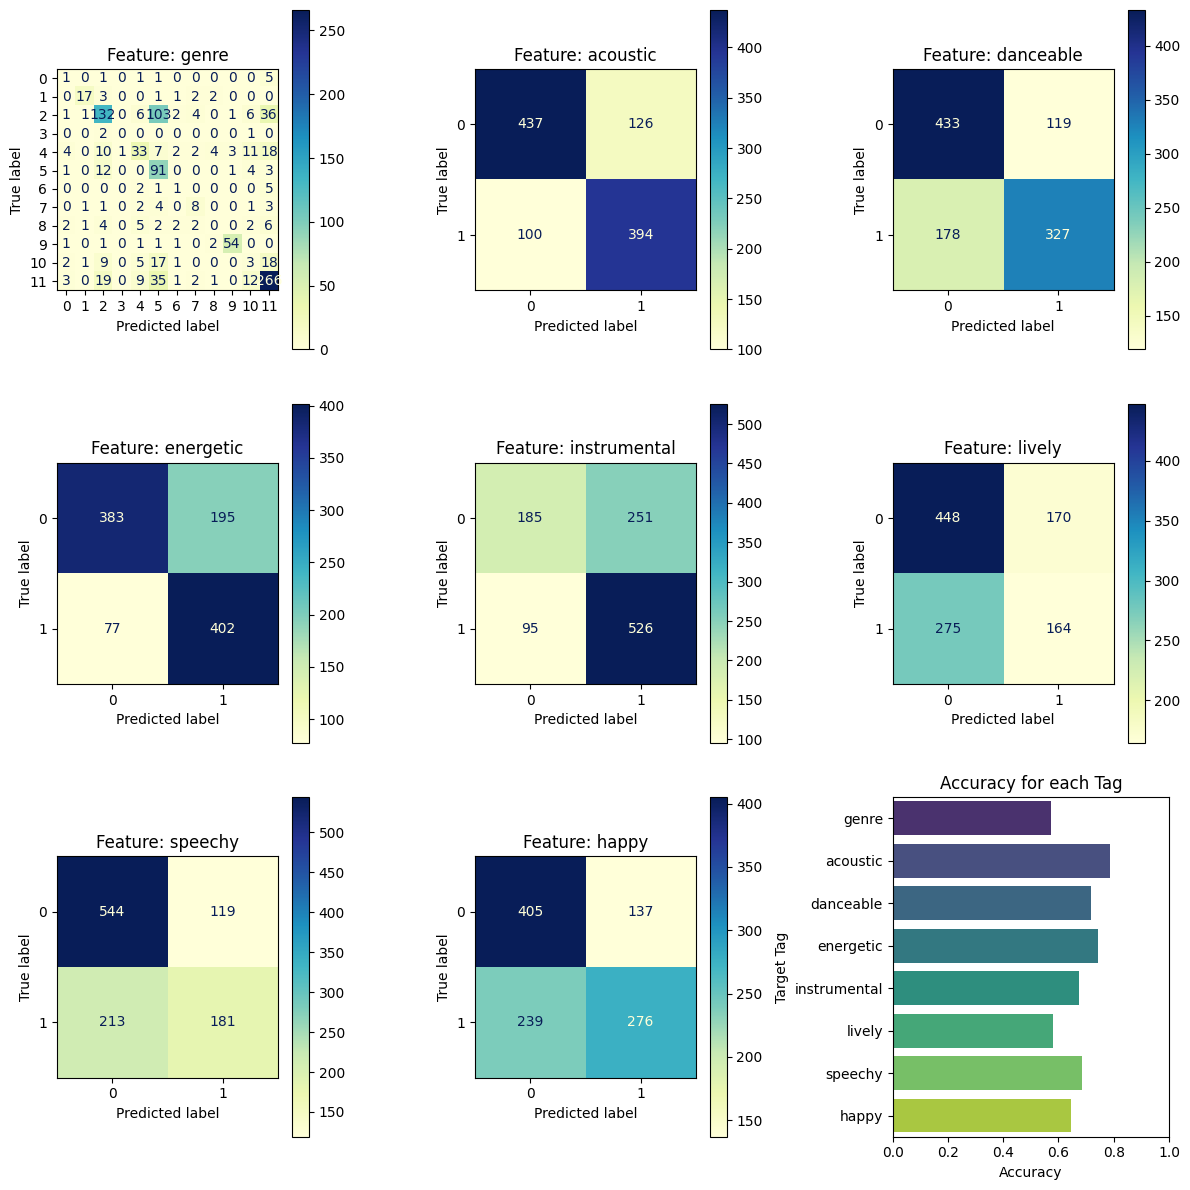

Feature Accuracies:
genre: 0.57
acoustic: 0.79
danceable: 0.72
energetic: 0.74
instrumental: 0.67
lively: 0.58
speechy: 0.69
happy: 0.64


In [32]:
labels = ['genre'] + list(EN_feature_mapping.values())

models = {
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'NaiveBayes': GaussianNB(),
    'NeuralNet': MLPClassifier(),
}

for fset, X in fsets.items():
    for name, model in models.items():
        print(f"\nEvaluating feature set `{fset}` using {name} classifier:")
        eval_classifier(model, X, y, labels, test_size=0.2)


Evaluating Mean MFCC feature set using Stratified Dummy classifier:


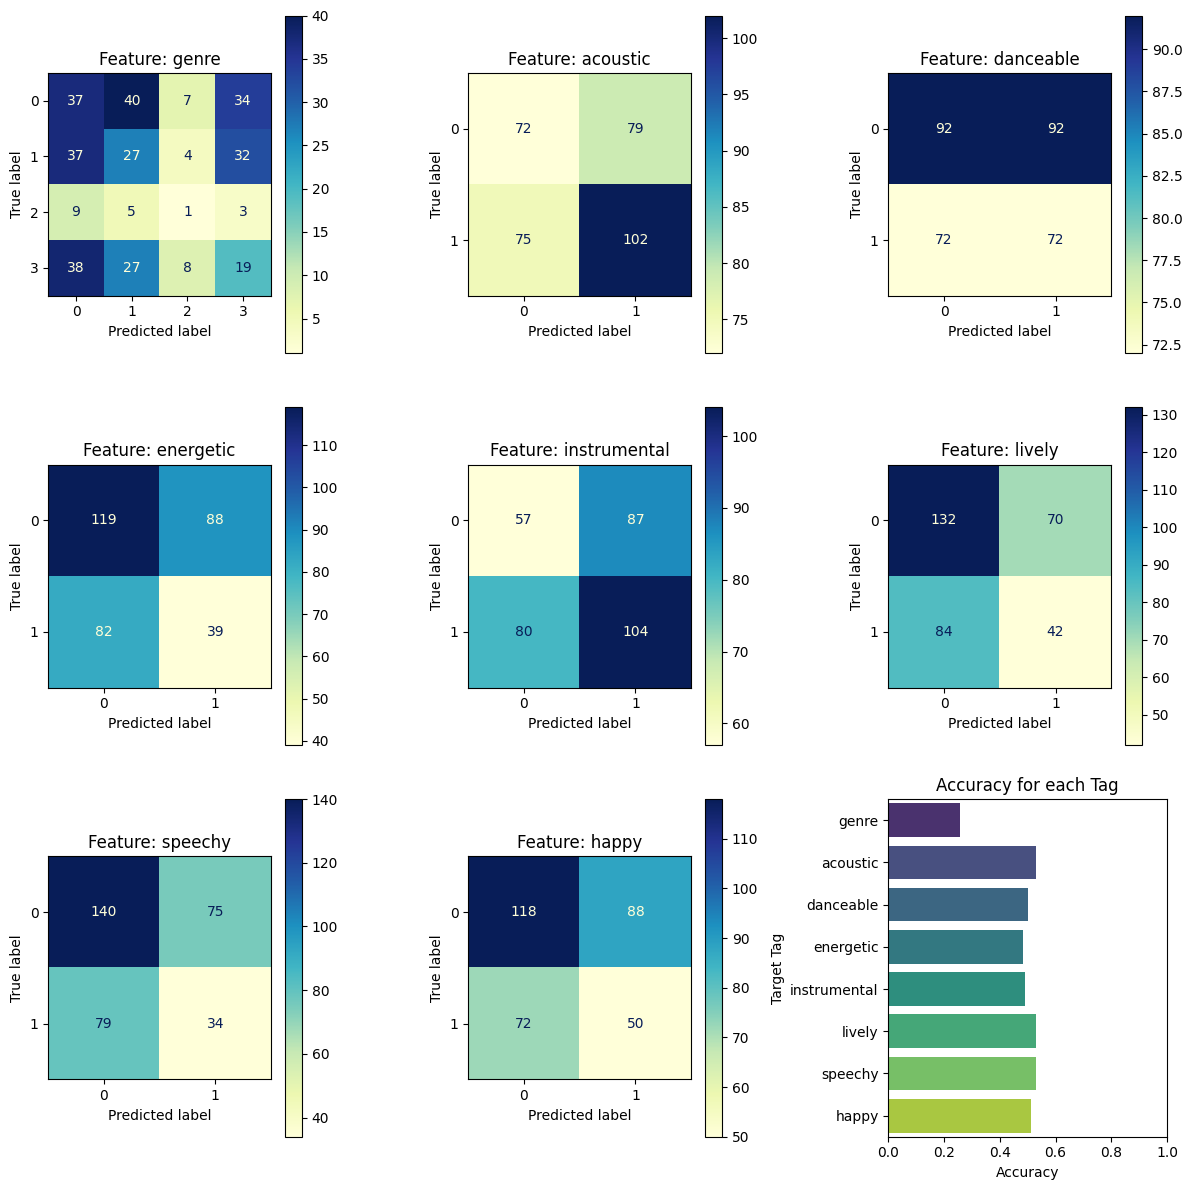

Feature Accuracies:
genre: 0.26
acoustic: 0.53
danceable: 0.50
energetic: 0.48
instrumental: 0.49
lively: 0.53
speechy: 0.53
happy: 0.51

Evaluating Mean & Std MFCC feature set using Stratified Dummy classifier:


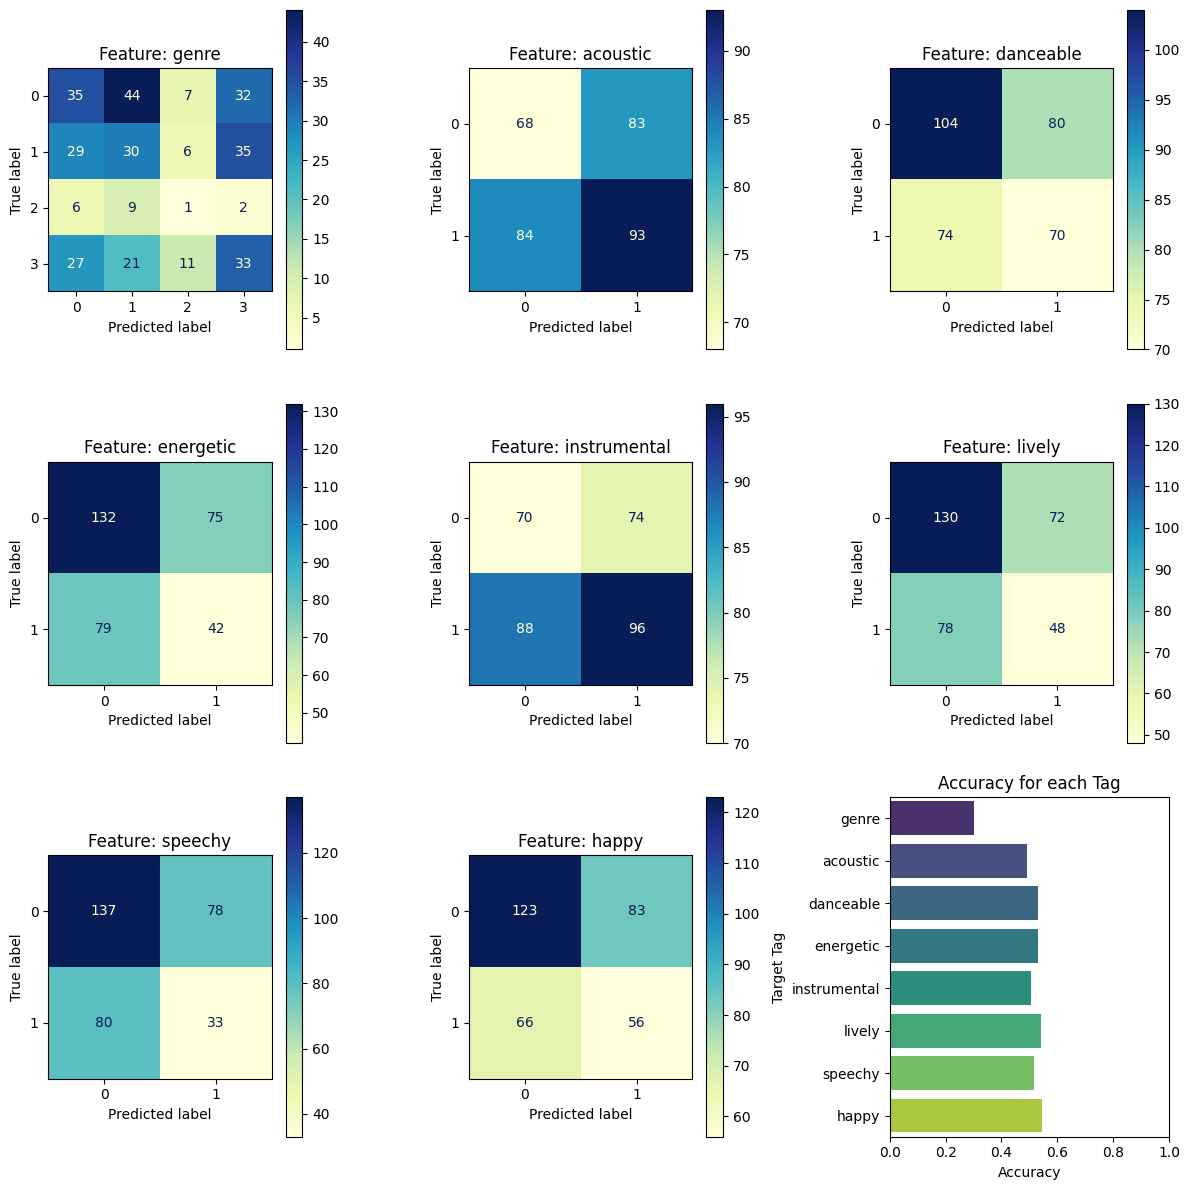

Feature Accuracies:
genre: 0.30
acoustic: 0.49
danceable: 0.53
energetic: 0.53
instrumental: 0.51
lively: 0.54
speechy: 0.52
happy: 0.55

Evaluating Mean Chroma feature set using Stratified Dummy classifier:


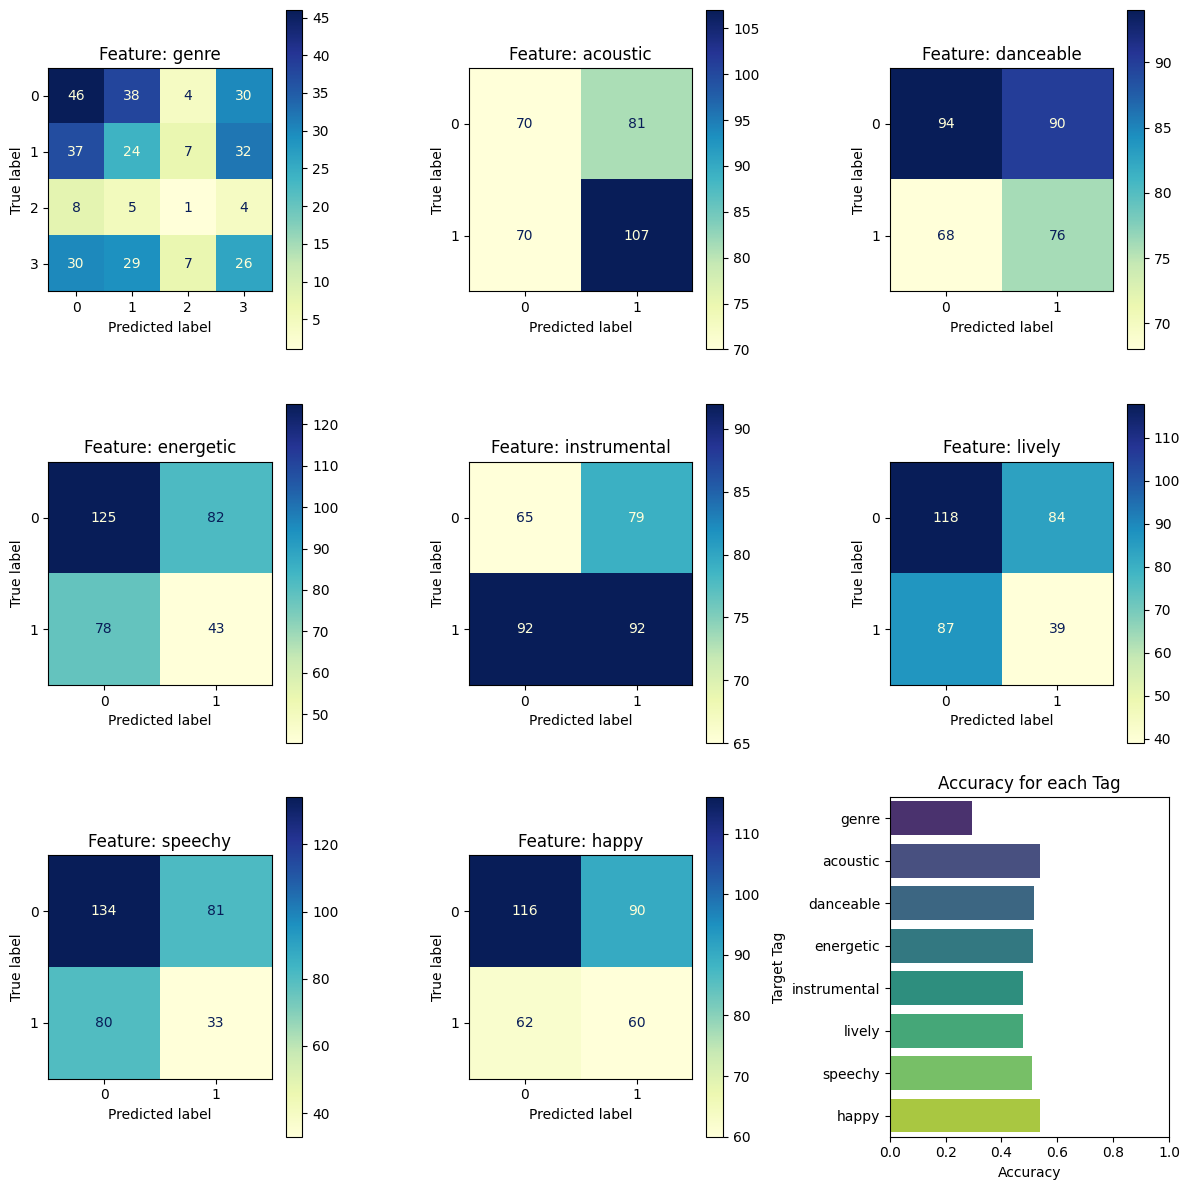

Feature Accuracies:
genre: 0.30
acoustic: 0.54
danceable: 0.52
energetic: 0.51
instrumental: 0.48
lively: 0.48
speechy: 0.51
happy: 0.54

Evaluating Mean & Std Chroma feature set using Stratified Dummy classifier:


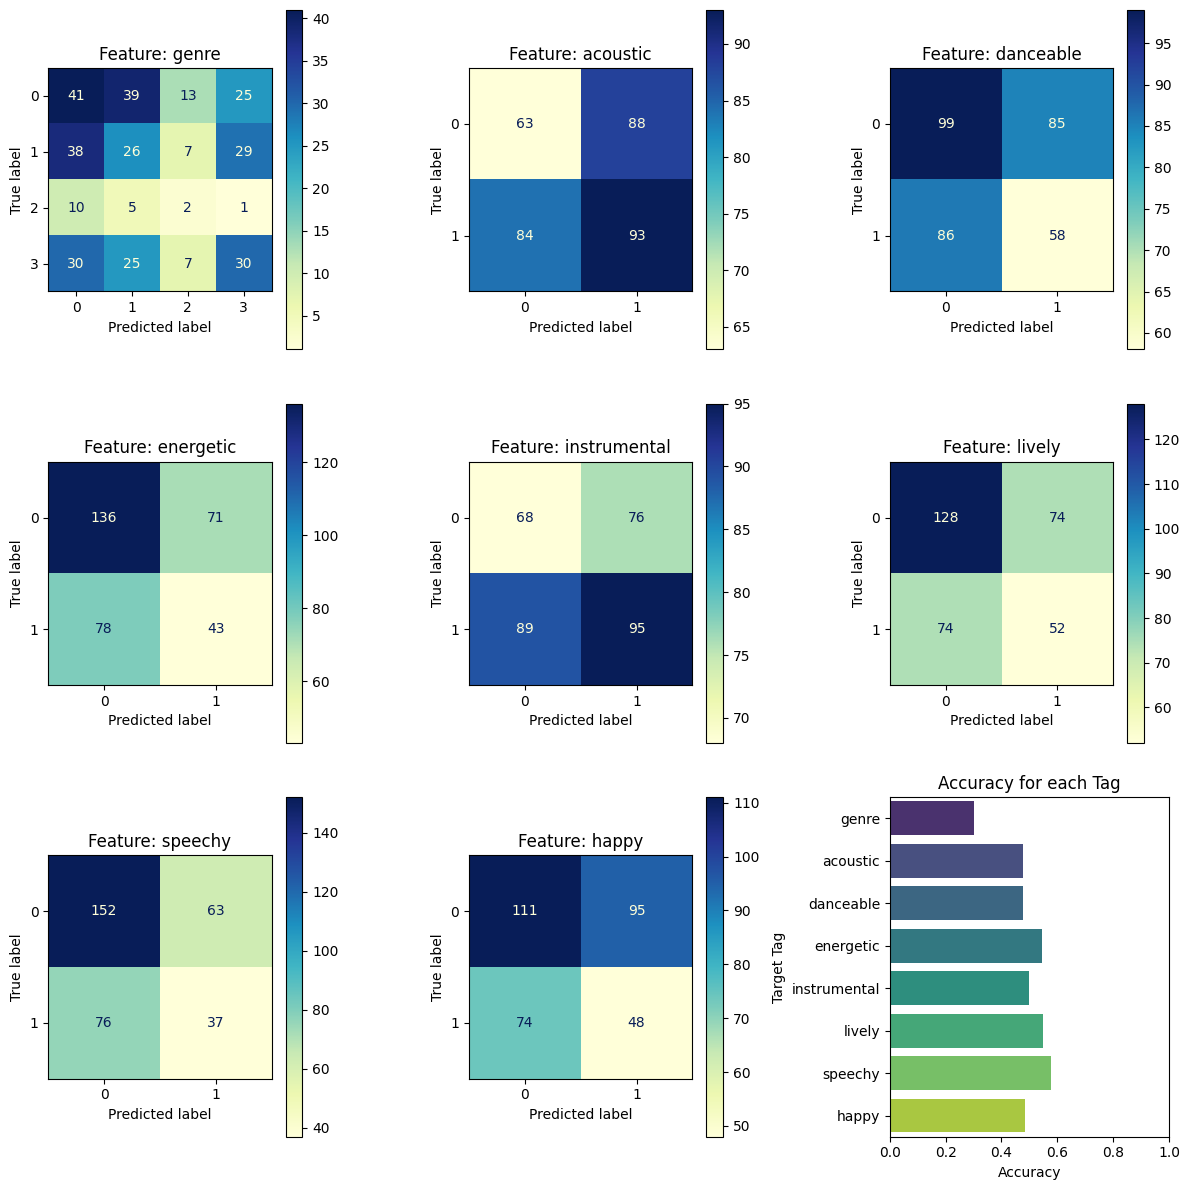

Feature Accuracies:
genre: 0.30
acoustic: 0.48
danceable: 0.48
energetic: 0.55
instrumental: 0.50
lively: 0.55
speechy: 0.58
happy: 0.48

Evaluating Mean MFCC & Chroma feature set using Stratified Dummy classifier:


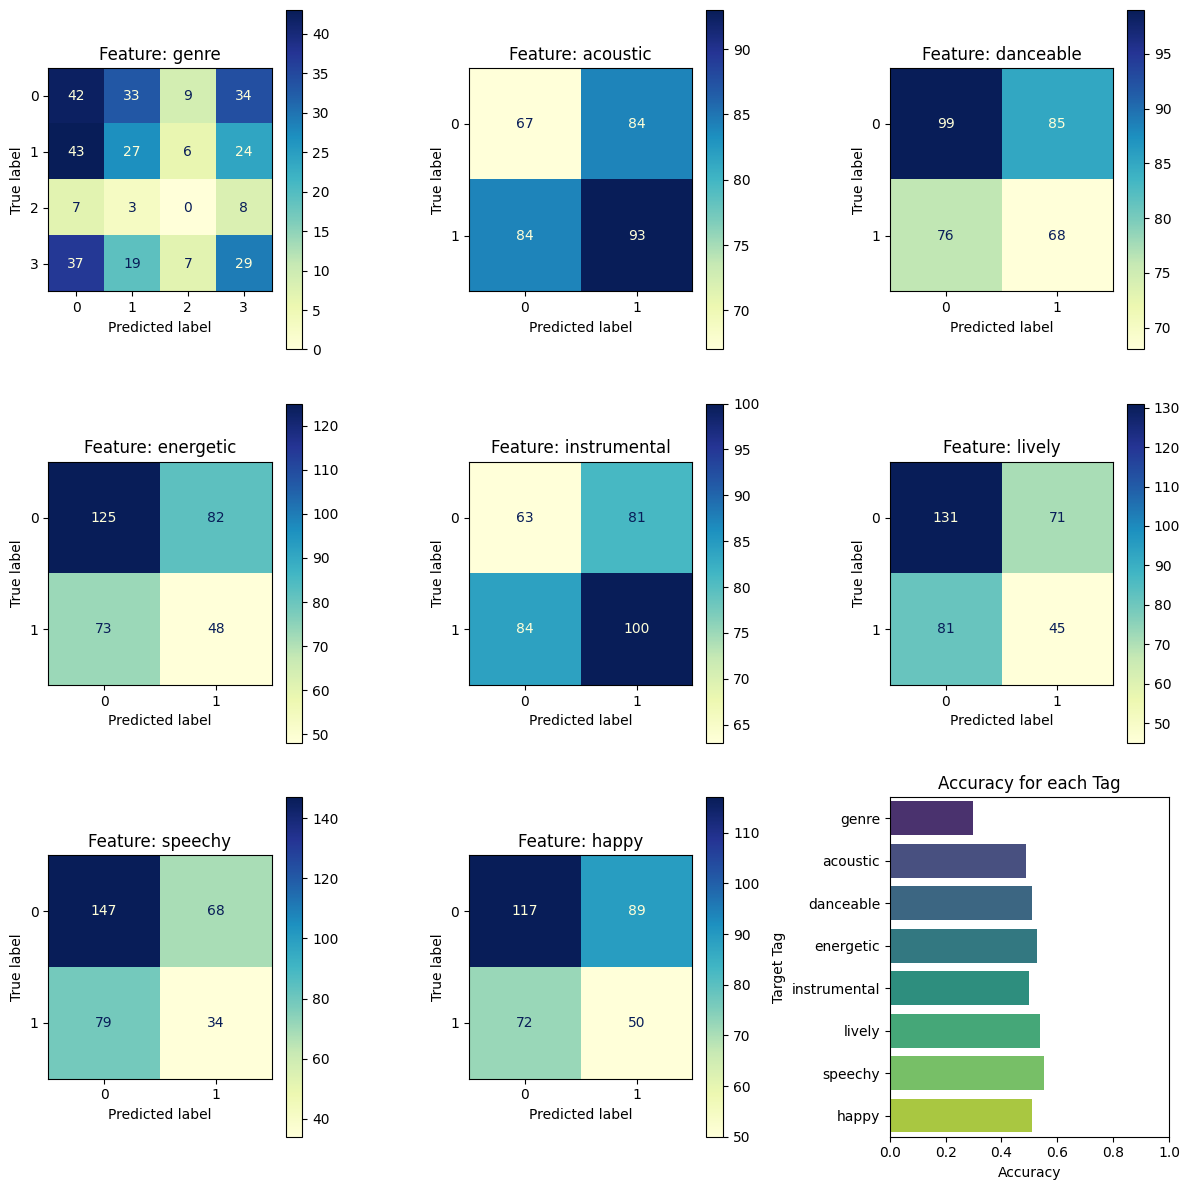

Feature Accuracies:
genre: 0.30
acoustic: 0.49
danceable: 0.51
energetic: 0.53
instrumental: 0.50
lively: 0.54
speechy: 0.55
happy: 0.51

Evaluating Tempo feature set using Stratified Dummy classifier:


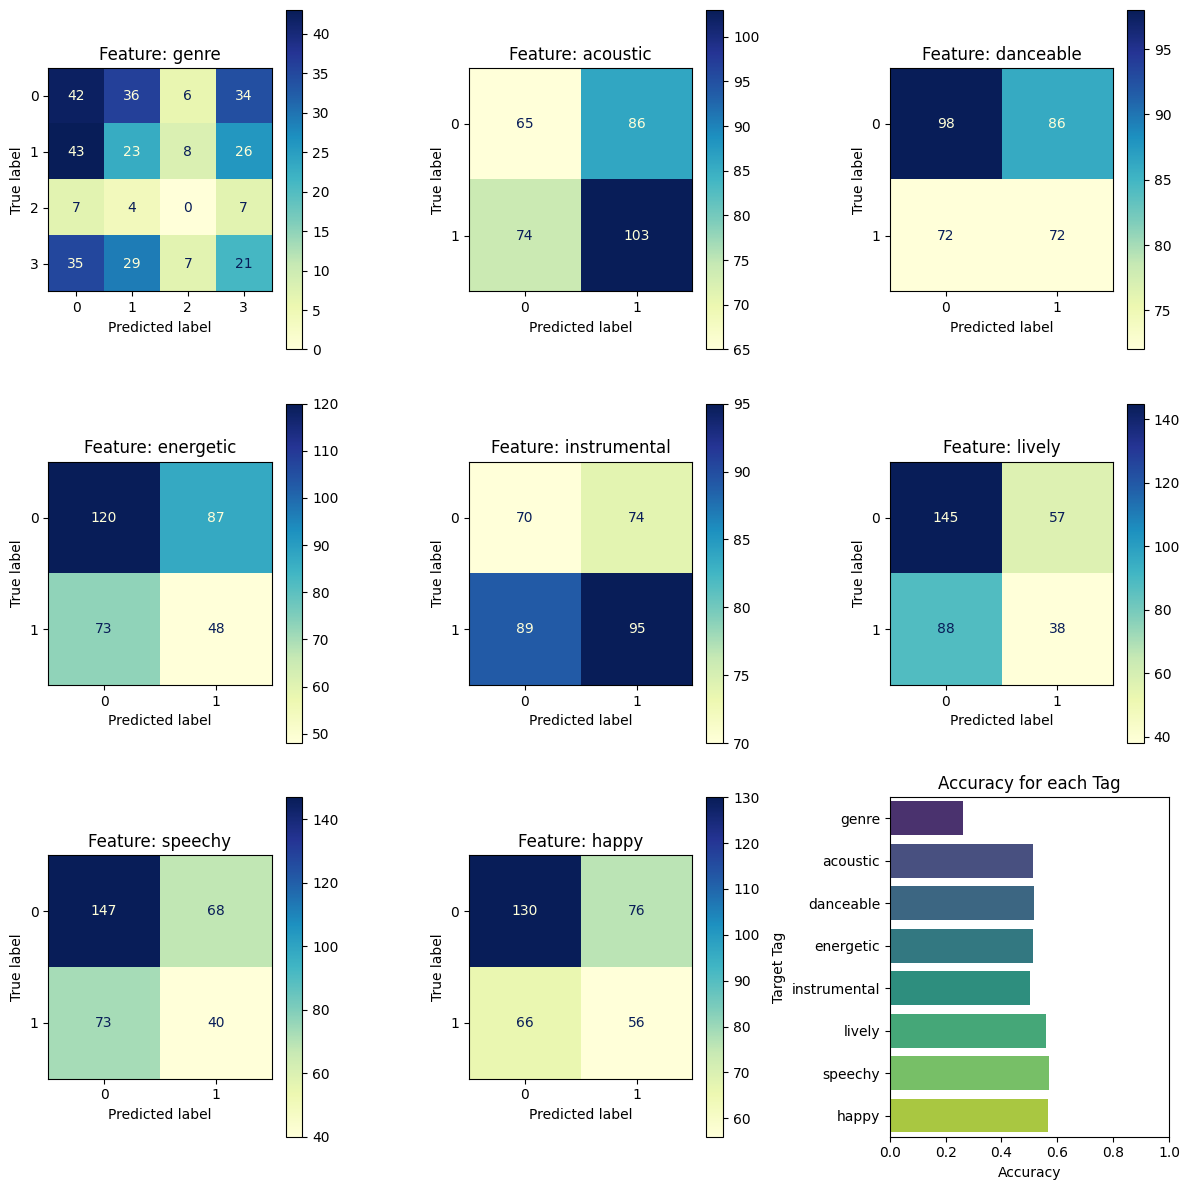

Feature Accuracies:
genre: 0.26
acoustic: 0.51
danceable: 0.52
energetic: 0.51
instrumental: 0.50
lively: 0.56
speechy: 0.57
happy: 0.57

Evaluating Mean MFCC & Tempo feature set using Stratified Dummy classifier:


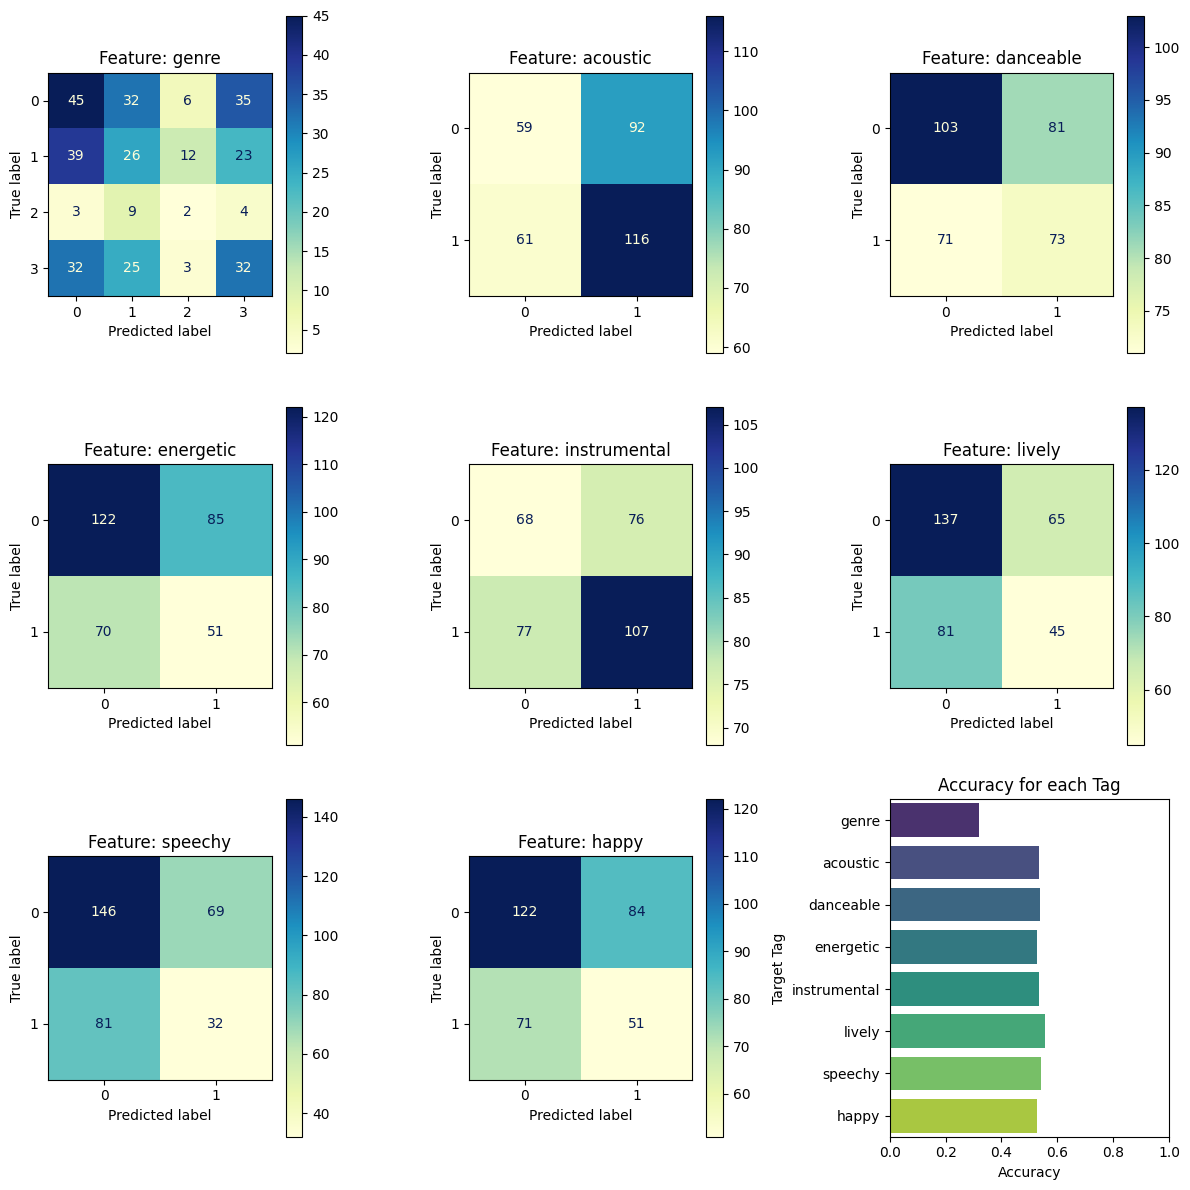

Feature Accuracies:
genre: 0.32
acoustic: 0.53
danceable: 0.54
energetic: 0.53
instrumental: 0.53
lively: 0.55
speechy: 0.54
happy: 0.53

Evaluating All Features feature set using Stratified Dummy classifier:


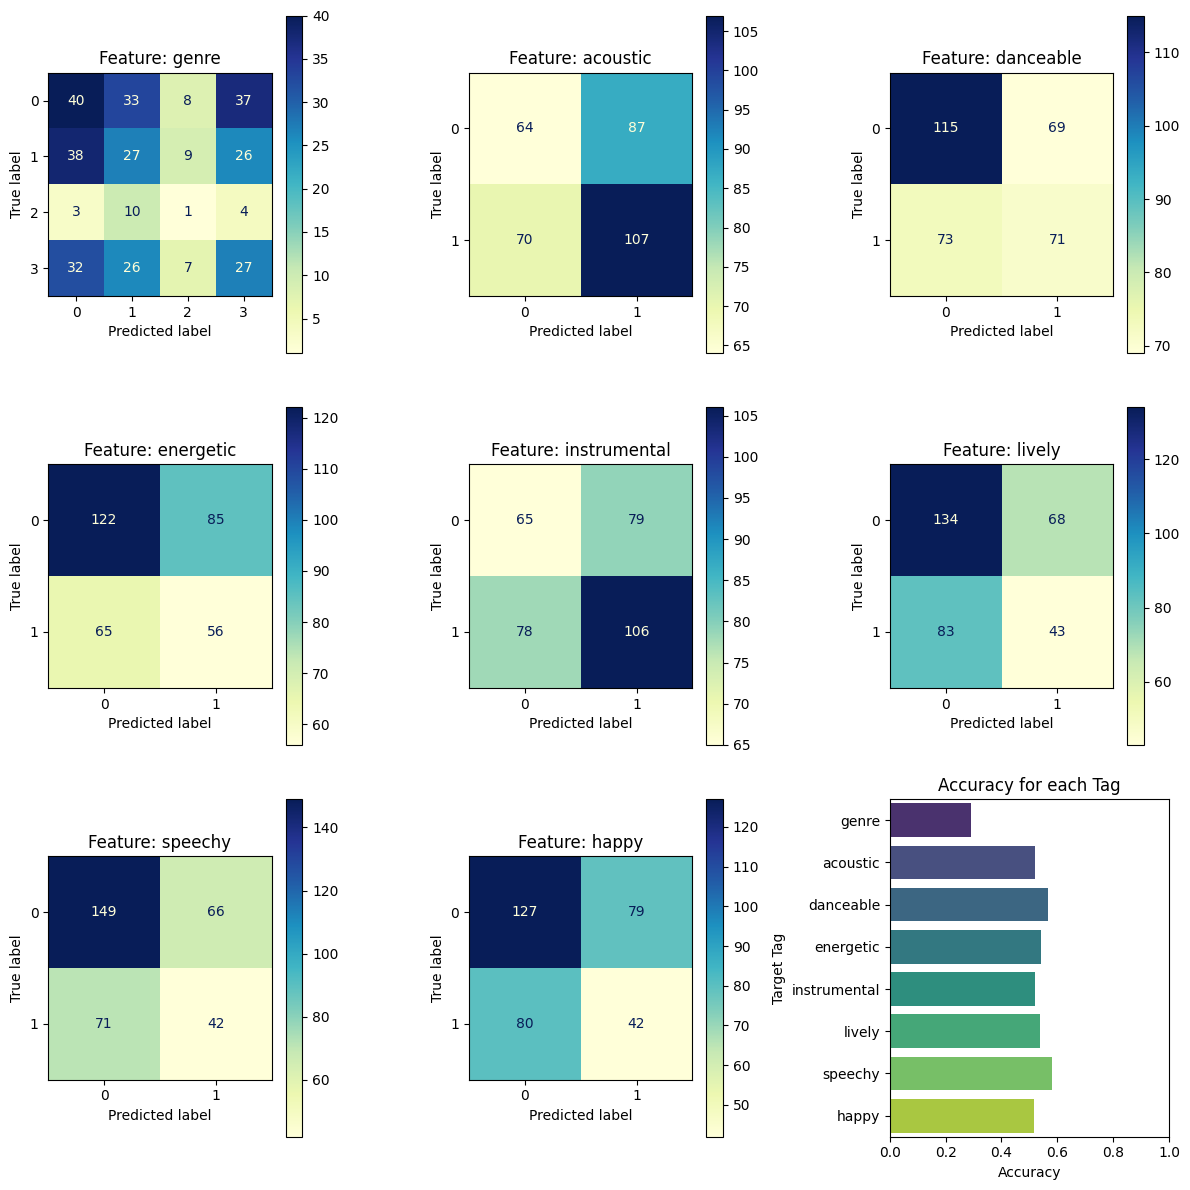

Feature Accuracies:
genre: 0.29
acoustic: 0.52
danceable: 0.57
energetic: 0.54
instrumental: 0.52
lively: 0.54
speechy: 0.58
happy: 0.52


In [50]:
# Evaluate Stratified Dummy classifier as benchmark to compare against
dummy = DummyClassifier(strategy='stratified')
for fset, X in fsets.items():
    print(f"\nEvaluating {fset} feature set using Stratified Dummy classifier:")
    eval_classifier(X, y, dummy, labels, test_size=0.4)